In [1]:
# Importing modules
%matplotlib inline
import numpy as np
from scipy import stats as sc
import matplotlib.pyplot as plt

# Regression

## The model

### Least square view

$$\begin{equation}
w_{opt} = \arg\max_{w} \frac{1}{2} \sum_n (y_n-X_n^{T} w)^{2} + \frac{\lambda}{2} \sum_f w_f^{q}
\end{equation}
$$

### Probabilistic view

Assume that there is gaussian noise in our data.

$$\begin{equation}
P(y~|~\mu,\sigma^{2}) = \frac{1}{(2\pi\sigma^{2})^{\frac{\sigma}{2}}} \exp -(\frac{1}{2\sigma^{2}}(y-\mu)^{T}(y-\mu))
\end{equation}
$$

$$\begin{equation}
\mu = Xw
\end{equation}
$$

The maximum likelihood gives the same solution to the least square solution.

$$\begin{equation}
w_{opt} = \arg\max_{w} \log P(y~|~\mu = Xw,\sigma^{2})
= \arg\max_{w} \frac{1}{2\sigma^{2}} \sum_n (y_n-X_n^{T} w)^{2} - C
\end{equation}
$$

The MAP estimate gives the same solution to the L2 regularized solution (ridge regression), if we assume gaussian prior on the weights with 0 mean and $\lambda^{-1} * I $ covariance.

$$\begin{equation}
w_{MAP} = \arg\max_{w} \log P(y~|~w,X) + \log P(w) - \log P(y~|~X)
= \arg\max_{w} \frac{1}{2\sigma^{2}} (y-Xw)^{T}(y-Xw) - \frac{\lambda}{2} w^{T}w + C
\end{equation}
$$

## Load the data

In [2]:
data = np.loadtxt('house.txt')
print data.shape

(506L, 14L)


### Predictors

The predictors in the data set:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 (USD)
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    percentage of lower status of the population
    14. MEDV     Median value of owner-occupied homes in 1000 (USD)

## Defining functions

### For normalizing the predictors

In [3]:
# normalize the data if it is needed
def FeatureNormalize(X):
    
    Mean = np.mean(X, axis = 0)
    STD = np.std(X, axis = 0)
    X_norm = (X-Mean)/STD
    
    return X_norm, Mean, STD

### For Ridge regression

In [4]:
# Ridge, L2 regression
def RidgeRegression(X, Y, lmbd):
    
    XTransp = X.T
    Covar = np.dot(XTransp,X)
    Reg = lmbd*np.identity(Covar.shape[1])
    Reg[-1,-1] = 0 # bias term at the end
    W_rr = np.dot(np.dot(np.linalg.inv(Reg+Covar),XTransp),Y)
        
    return W_rr

### For the Bayesian regression

In [5]:
# Bayesian regressian assuming shared variance, and uncorrelated dimensions
def BayesianRegressionPost(X, Y, Sgm, lmbd):
    
    XTransp = X.T
    Covariates = np.dot(XTransp,X)
    Reg = lmbd*np.identity(Covariates.shape[1])
    Reg[-1,-1] = 0 # bias term at the end

    PostCovar = np.linalg.inv(Reg+((1/(Sgm**2.0)) * Covariates))
    PostMean = np.dot(np.dot(np.linalg.inv((Reg*Sgm**2.0)+Covariates), XTransp), Y)

    return PostMean, PostCovar


# predictive distributions on new data points
def BayesianRegressionPred(PostMean, PostCovar, X0, Sgm, lmbd):
    
    PredCovar = Sgm**2 + np.dot(np.dot(X0,PostCovar),X0.T)
    PredCovar = PredCovar.diagonal()
    PredMean = np.dot(X0,PostMean)
        
    return PredMean, PredCovar

### For the sparse regression

In [6]:
def SparseRegCostGrad(X,Y,W,lmbd):
    
    N = X.shape[0]
    
    # prediction for y
    X_pred = np.dot(X,W) # the last one is the bias term
    
    # L1 norm
    L1 = np.sum(np.absolute(W[0:-1]))
    
    #cost
    Cost =  0.5 * np.dot(X_pred-Y, X_pred-Y) + (lmbd/2.0)*L1

    # gradient
    Grad = (1.0/N) * np.dot(X[:,0:-1].T, X_pred-Y) + (lmbd/N)*W[0:-1]
    GradBias = (1.0/N) * np.dot(X[:,-1].T, X_pred-Y)
    Grad = np.hstack((Grad, GradBias))

    return Cost, Grad


## Fitting the data and test the accuracy with cross validation

### Ridge and Bayesian regression (Without normalization)

In [7]:
split = 6
examples = data.shape[0]
partition = round(examples/split)
NcrossVal = 10
lmbd = 1
Sgm = 1

MeanRidgeAccuracy = np.zeros(NcrossVal)
X_test_pred = np.zeros((partition, split, NcrossVal))
all_y_test = np.zeros((partition, split, NcrossVal))

Bayes_pred_m = np.zeros((partition, split, NcrossVal))
Bayes_pred_c = np.zeros((partition, split, NcrossVal))

for crossVal in range(NcrossVal):
    
    print 'Validation round: ', crossVal
    
    # let us train and test our data for each possible partition
    np.random.shuffle(data)

    RidgeSQErr = np.zeros(split)
    
    for i in range(split):
        
        print 'Split NO: ', i
        
        # creating training and test sets
        testidx = np.arange(examples)
        testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
        X_test = data[testidx,0:-1]
        X_test = np.hstack((X_test, np.array([np.ones(X_test.shape[0])]).T)) # adding the bias term
        Y_test = data[testidx,-1]
        X_train = data[np.invert(testidx),0:-1]
        X_train = np.hstack((X_train, np.array([np.ones(X_train.shape[0])]).T)) # adding the bias term
        Y_train = data[np.invert(testidx),-1]
        
        # fitting the training data with max likelihood with the ridge regression
        W_RR = RidgeRegression(X_train, Y_train, lmbd)
        
        # Bayesian model with gaussian noise with uncorrelated unit variance
        PostM, PostC = BayesianRegressionPost(X_train, Y_train, Sgm, lmbd)
        
        #Predicting values using the Bayesian distributions
        PredM, PredC = BayesianRegressionPred(PostM, PostC, X_test, Sgm, lmbd)
        Bayes_pred_m[:,i,crossVal] = PredM
        Bayes_pred_c[:,i,crossVal] = PredC
        
        # predicting the test values
        X_test_pred[:,i,crossVal] = np.dot(X_test, W_RR)
        all_y_test[:,i,crossVal] = Y_test
        
        # the accuracy
        RidgeSQErr[i] = np.mean(np.square(Y_test - X_test_pred[:,i,crossVal]))

    MeanRidgeAccuracy[crossVal] = np.mean(RidgeSQErr)

Validation round:  0
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  1
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  2
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  3
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  4
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  5
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  6
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  7
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  8
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  9
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Ridge regression results

The average prediction error of the ridge regression on the validation rounds were:  4.89195486778


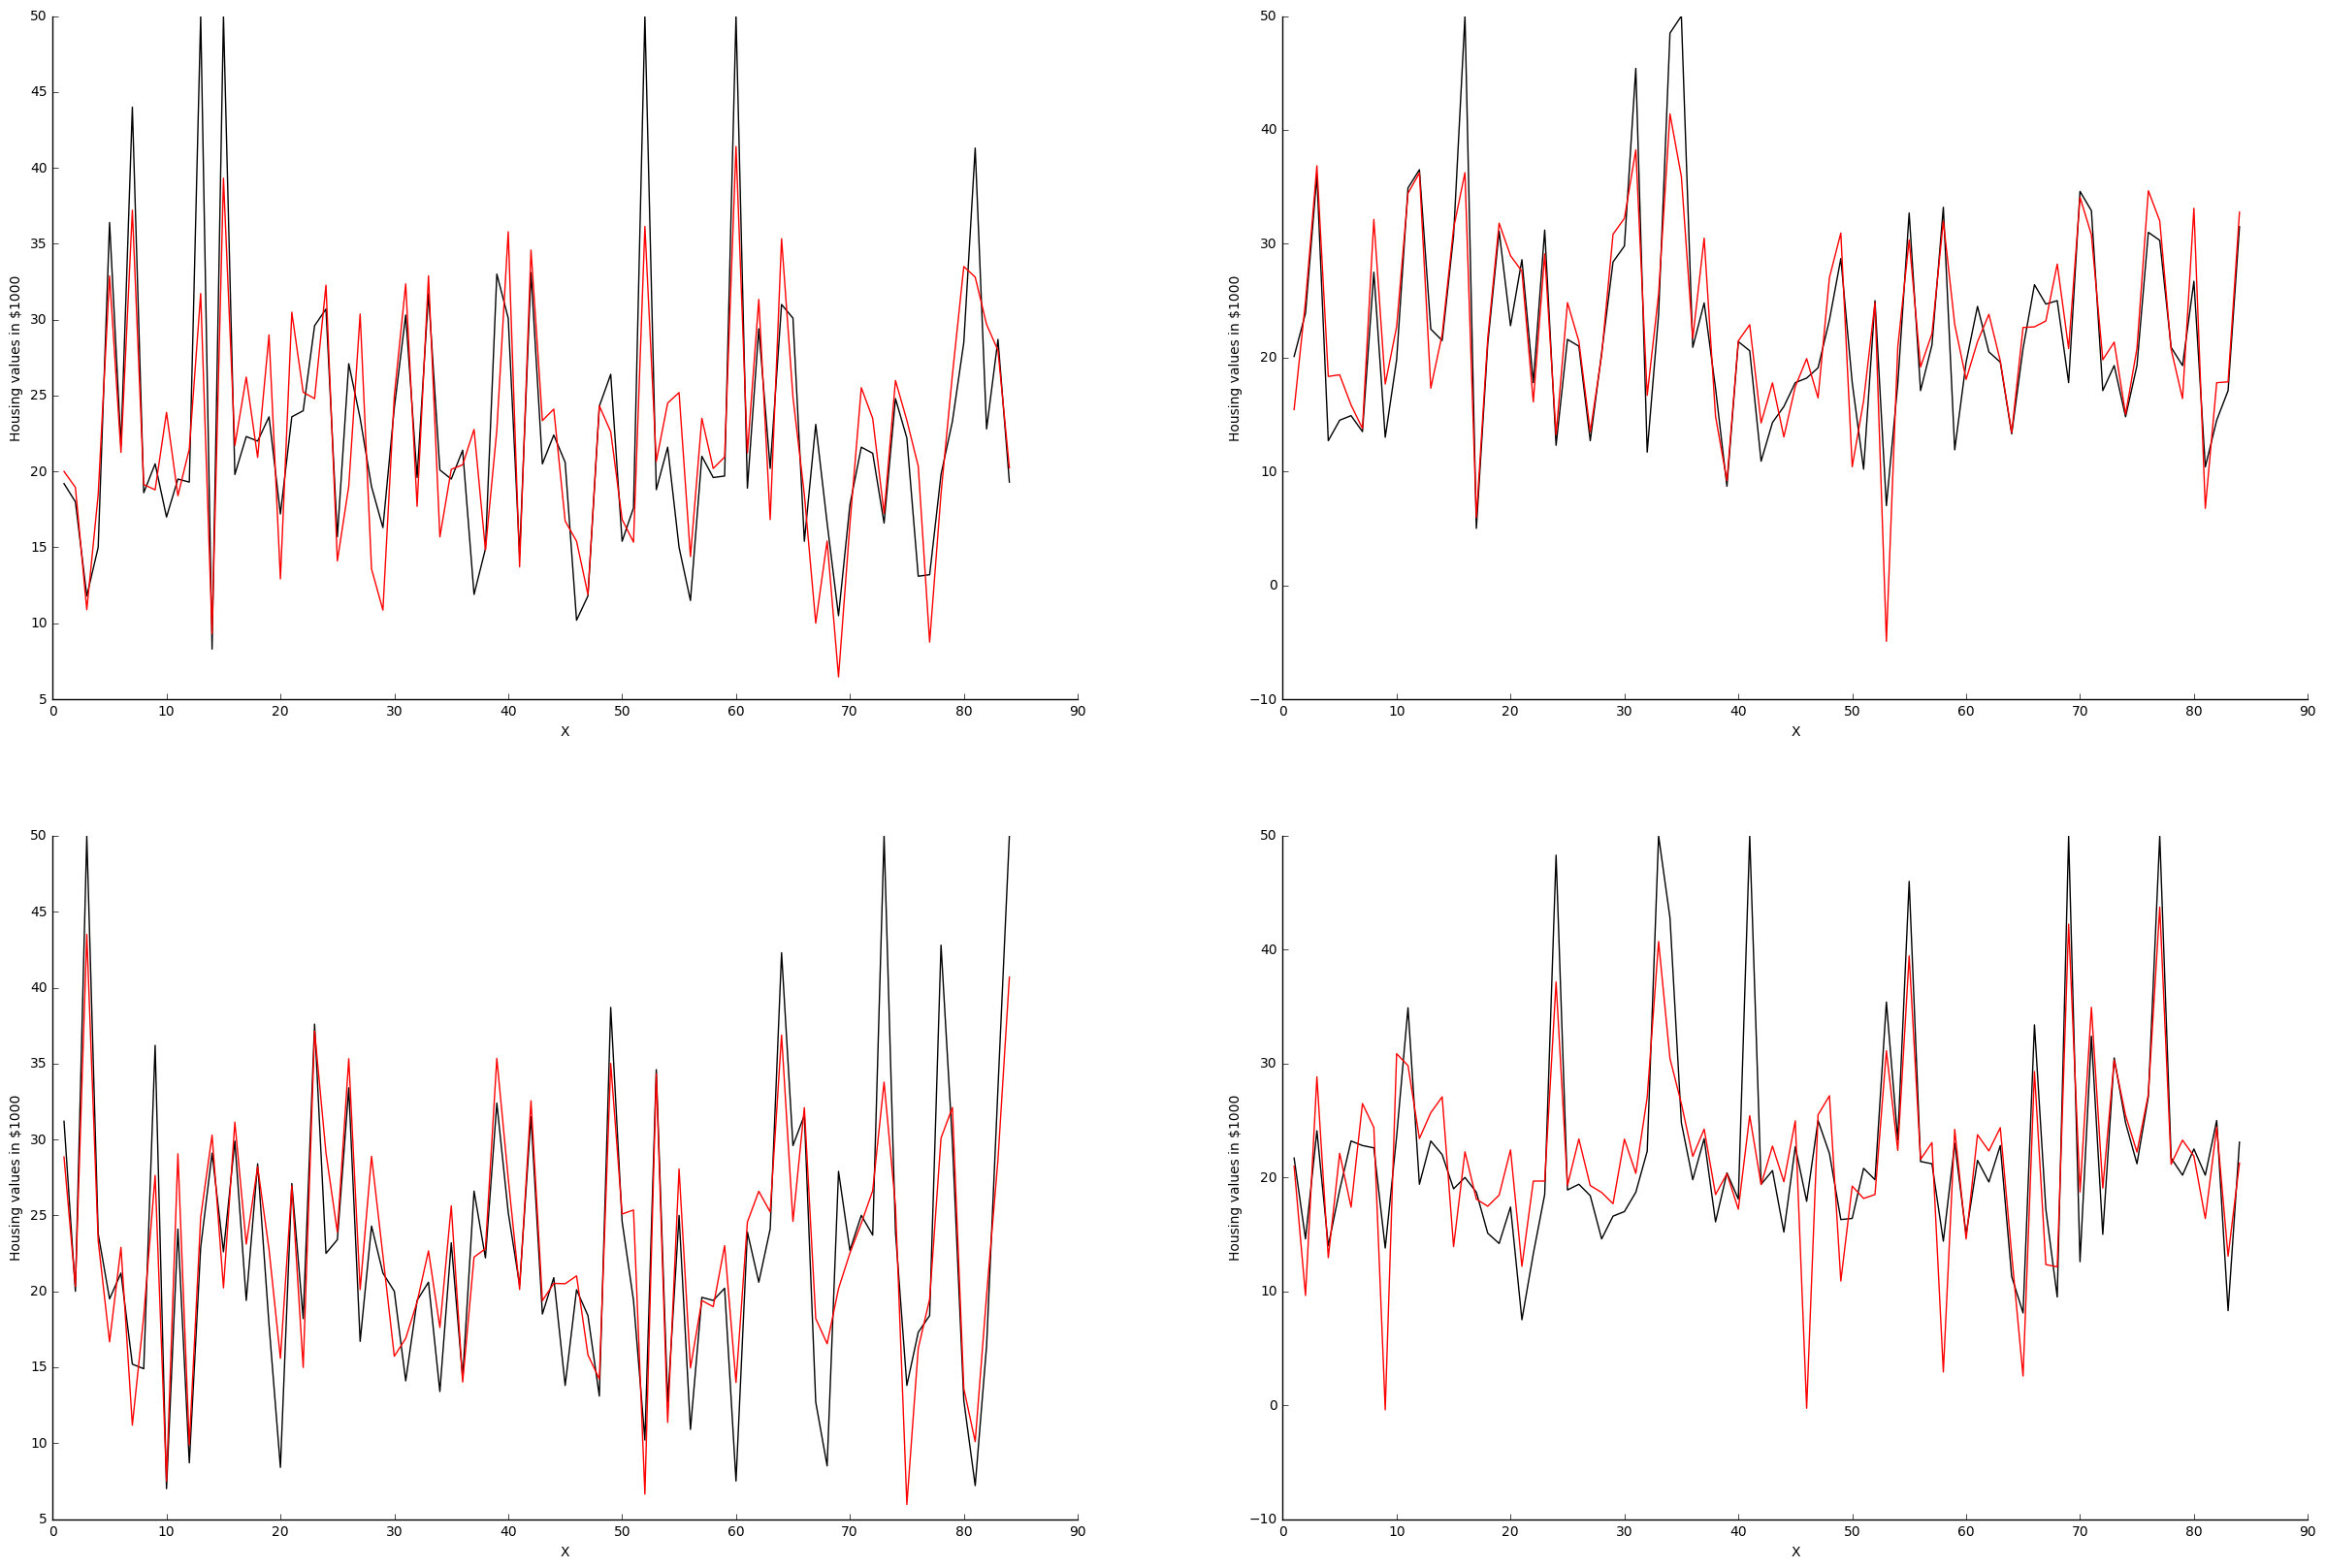

The weights of the predictors:  [(1, -0.1177), (2, 0.0444), (3, 0.0293), (4, 2.8364), (5, -10.6336), (6, 4.5513), (7, -0.0148), (8, -1.3415), (9, 0.2644), (10, -0.0129), (11, -0.8381), (12, 0.0093), (13, -0.4813), (14, 26.2243)]


In [8]:
print "The average prediction error of the ridge regression on the validation rounds were: ", np.mean(np.sqrt(MeanRidgeAccuracy))

# plotting the accuracy of the predictions
fig,ax = plt.subplots(2,2, figsize=(30, 20),squeeze=False)
ax = ax.ravel()

plot=0
for i in range(2):
    for j in range(2):
        ax[plot].plot(range(1,all_y_test[:,i,j].shape[0]+1),all_y_test[:,i,j], 'k-')
        ax[plot].plot(range(1,X_test_pred[:,i,j].shape[0]+1),X_test_pred[:,i,j], 'r-')
        ax[plot].spines['right'].set_visible(False)
        ax[plot].spines['top'].set_visible(False)
        ax[plot].xaxis.set_ticks_position('bottom')
        ax[plot].yaxis.set_ticks_position('left')
        ax[plot].set_xlabel('X')
        ax[plot].set_ylabel('Housing values in $1000')
        plot = plot+1
plt.show()

print 'The weights of the predictors: ', zip(range(1,W_RR.shape[0]+1),[round(W_RR[i],4) for i in range(W_RR.shape[0])])

The predictors in the data set:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 (USD)
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    percentage of lower status of the population
    14. MEDV     Median value of owner-occupied homes in 1000 (USD)

#### Bayesian regression result

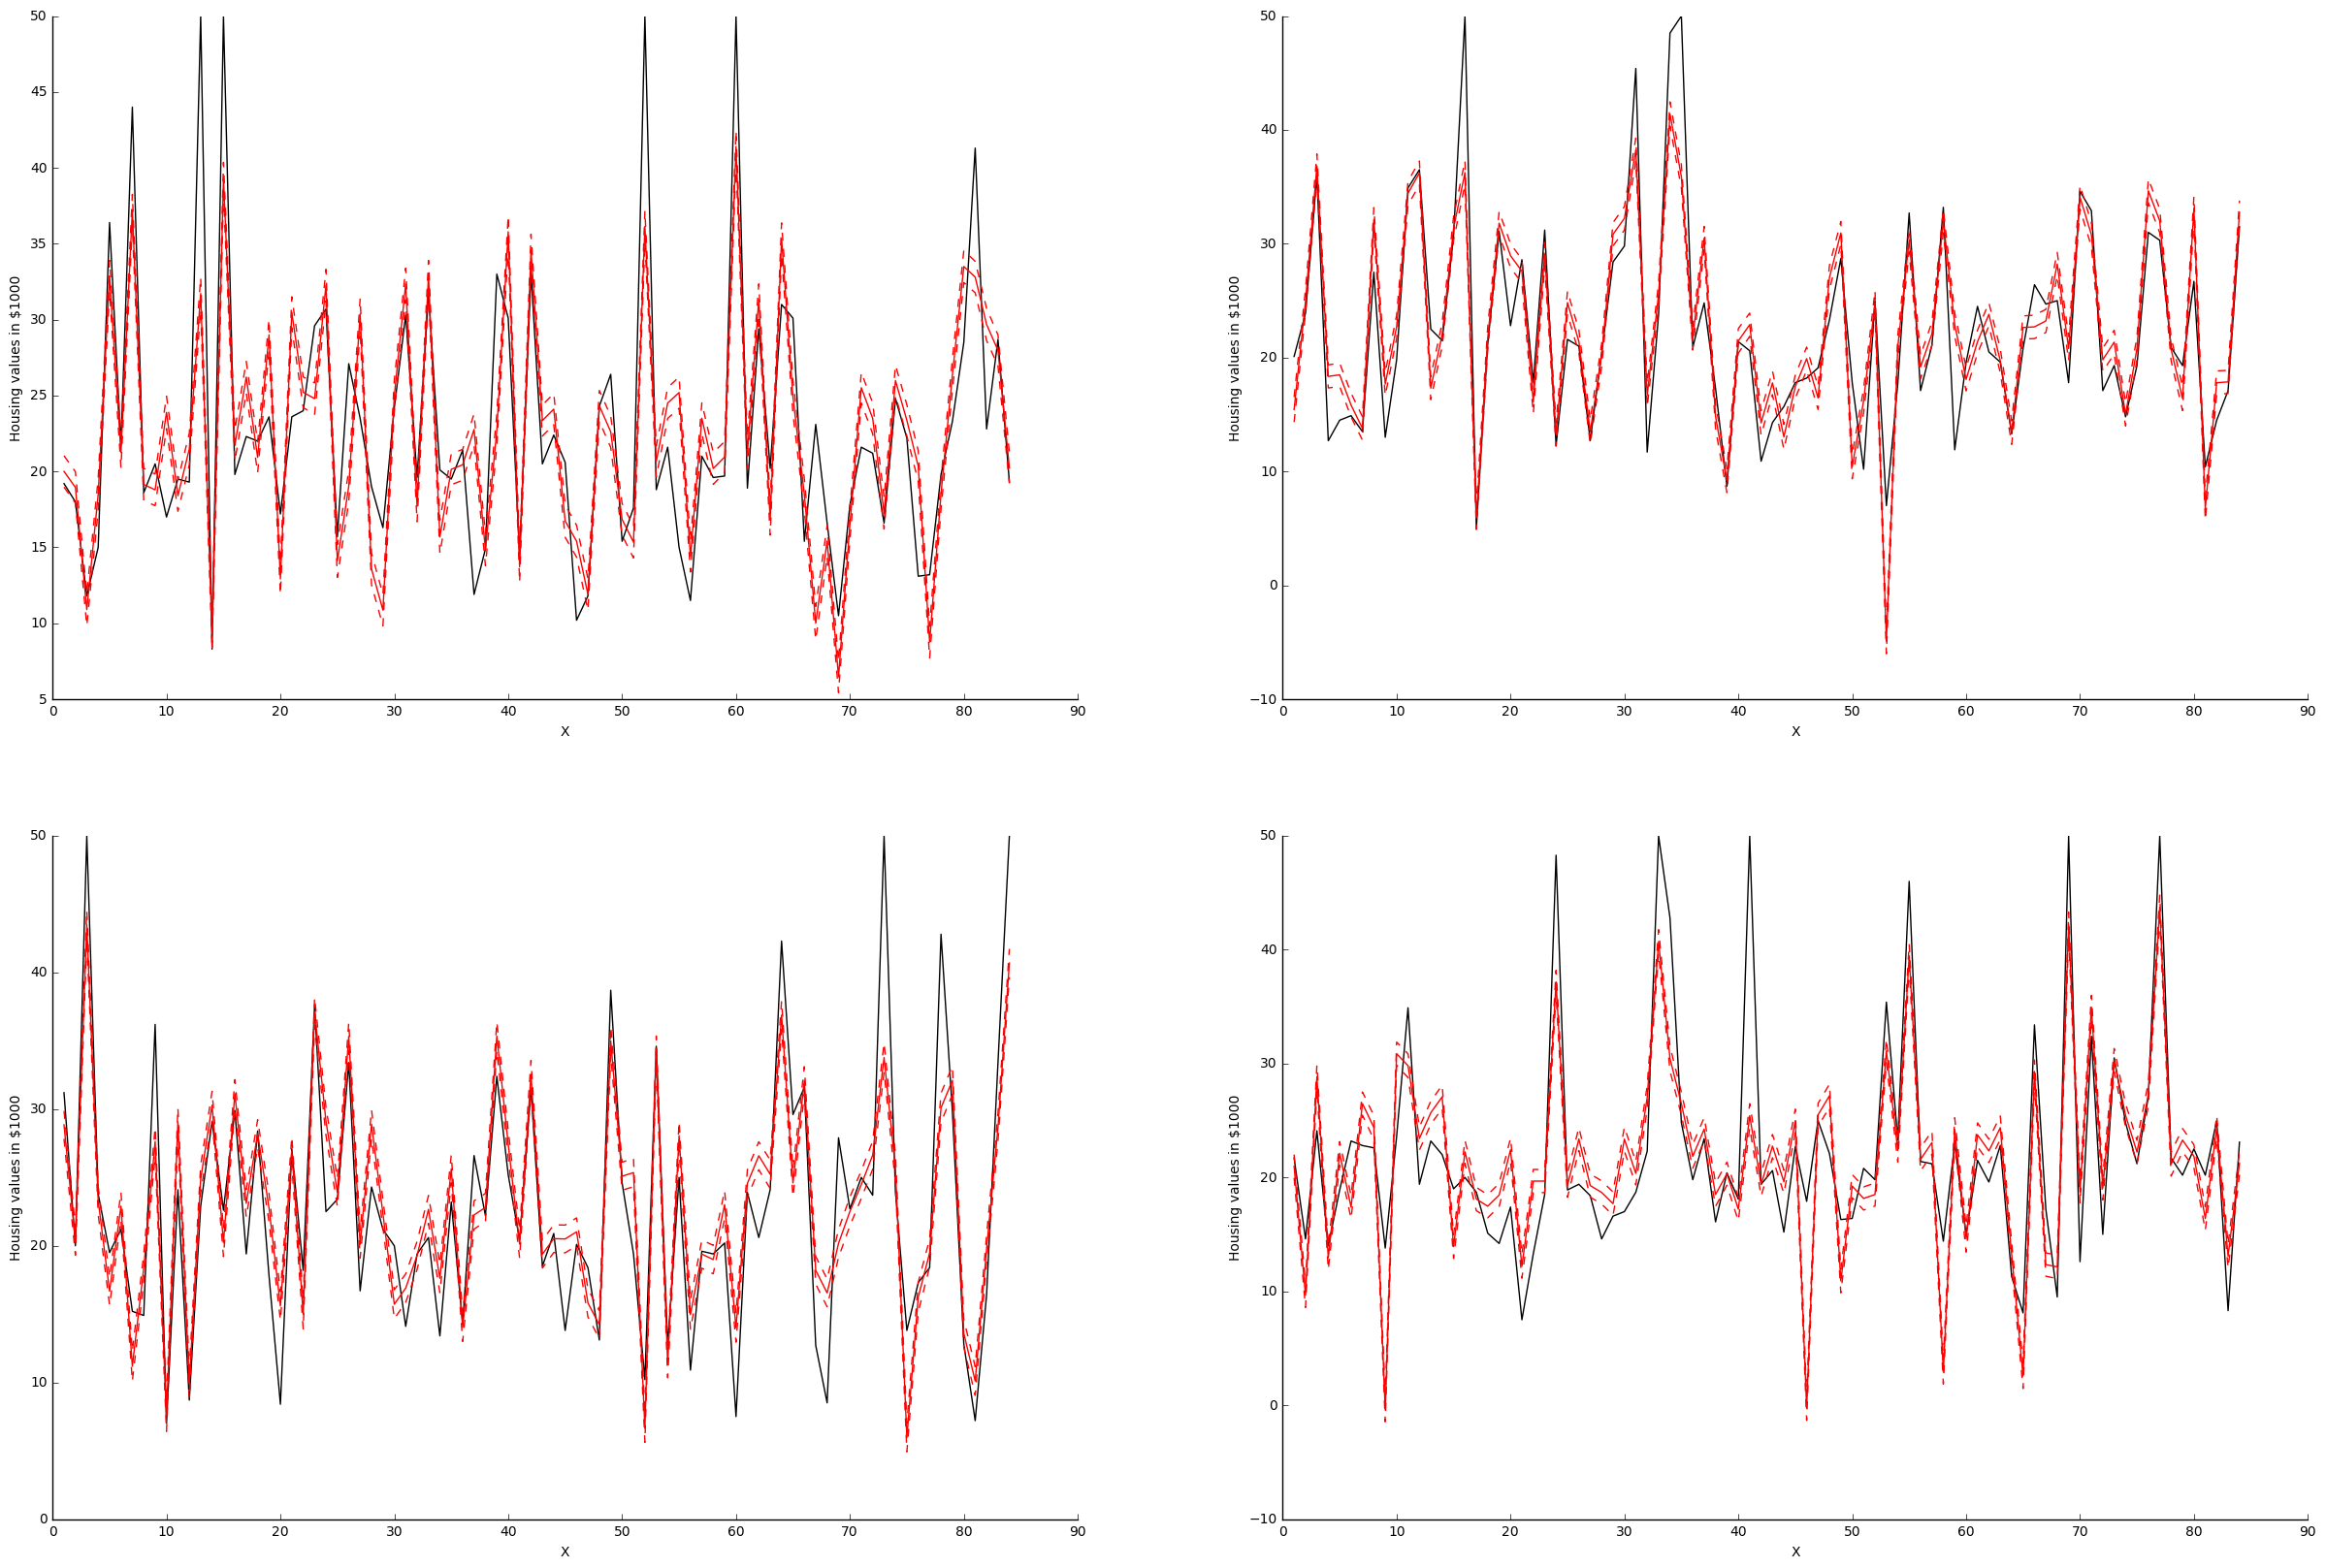

In [9]:
# plotting the accuracy of the predictions
fig,ax = plt.subplots(2,2, figsize=(30, 20),squeeze=False)
ax = ax.ravel()

plot=0
for i in range(2):
    for j in range(2):
        ax[plot].plot(range(1,all_y_test[:,i,j].shape[0]+1),all_y_test[:,i,j], 'k-')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j], 'r-')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j]+Bayes_pred_c[:,i,j], 'r--')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j]-Bayes_pred_c[:,i,j], 'r--')
        ax[plot].spines['right'].set_visible(False)
        ax[plot].spines['top'].set_visible(False)
        ax[plot].xaxis.set_ticks_position('bottom')
        ax[plot].yaxis.set_ticks_position('left')
        ax[plot].set_xlabel('X')
        ax[plot].set_ylabel('Housing values in $1000')
        plot = plot+1
plt.show()

### Ridge and Bayesian regression (With normalization)

In [10]:
# normalizing the predictors
X_norm, Mean, STD = FeatureNormalize(data)
X_norm[:,-1] = data[:,-1] # I should not have normalized the Y variable

In [11]:
split = 6
examples = data.shape[0]
partition = round(examples/split)
NcrossVal = 10
Sgm = 1
lmbd = 1

MeanRidgeAccuracy = np.zeros(NcrossVal)
X_test_pred = np.zeros((partition, split, NcrossVal))
all_y_test = np.zeros((partition, split, NcrossVal))


Bayes_pred_m = np.zeros((partition, split, NcrossVal))
Bayes_pred_c = np.zeros((partition, split, NcrossVal))

for crossVal in range(NcrossVal):
    
    print 'Validation round: ', crossVal
    
    # let us train and test our data for each possible partition
    np.random.shuffle(X_norm)

    RidgeSQErr = np.zeros(split)
    
    for i in range(split):
        
        print 'Split NO: ', i
        
        # creating training and test sets
        testidx = np.arange(examples)
        testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
        X_test = X_norm[testidx,0:-1]
        X_test = np.hstack((X_test, np.array([np.ones(X_test.shape[0])]).T)) # adding the bias term
        Y_test = X_norm[testidx,-1]
        
        X_train = X_norm[np.invert(testidx),0:-1]
        X_train = np.hstack((X_train, np.array([np.ones(X_train.shape[0])]).T)) # adding the bias term
        Y_train = X_norm[np.invert(testidx),-1]
        
        # fitting the training data with max likelihood with the ridge regression
        W_RR = RidgeRegression(X_train, Y_train, lmbd)
        
        # Bayesian model with gaussian noise with uncorrelated unit variance
        PostM, PostC = BayesianRegressionPost(X_train, Y_train, Sgm, lmbd)
        
        #Predicting values using the Bayesian distributions
        PredM, PredC = BayesianRegressionPred(PostM, PostC, X_test, Sgm, lmbd)
        Bayes_pred_m[:,i,crossVal] = PredM
        Bayes_pred_c[:,i,crossVal] = PredC

        # predicting the test values
        X_test_pred[:,i,crossVal] = np.dot(X_test, W_RR)
        all_y_test[:,i,crossVal] = Y_test
        
        # the accuracy
        RidgeSQErr[i] = np.mean(np.square(Y_test - X_test_pred[:,i,crossVal]))

    MeanRidgeAccuracy[crossVal] = np.mean(RidgeSQErr)

Validation round:  0
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  1
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  2
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  3
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  4
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  5
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  6
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  7
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  8
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  9
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Ridge regression results

The average prediction error of the ridge regression on the validation rounds were:  4.89267845928


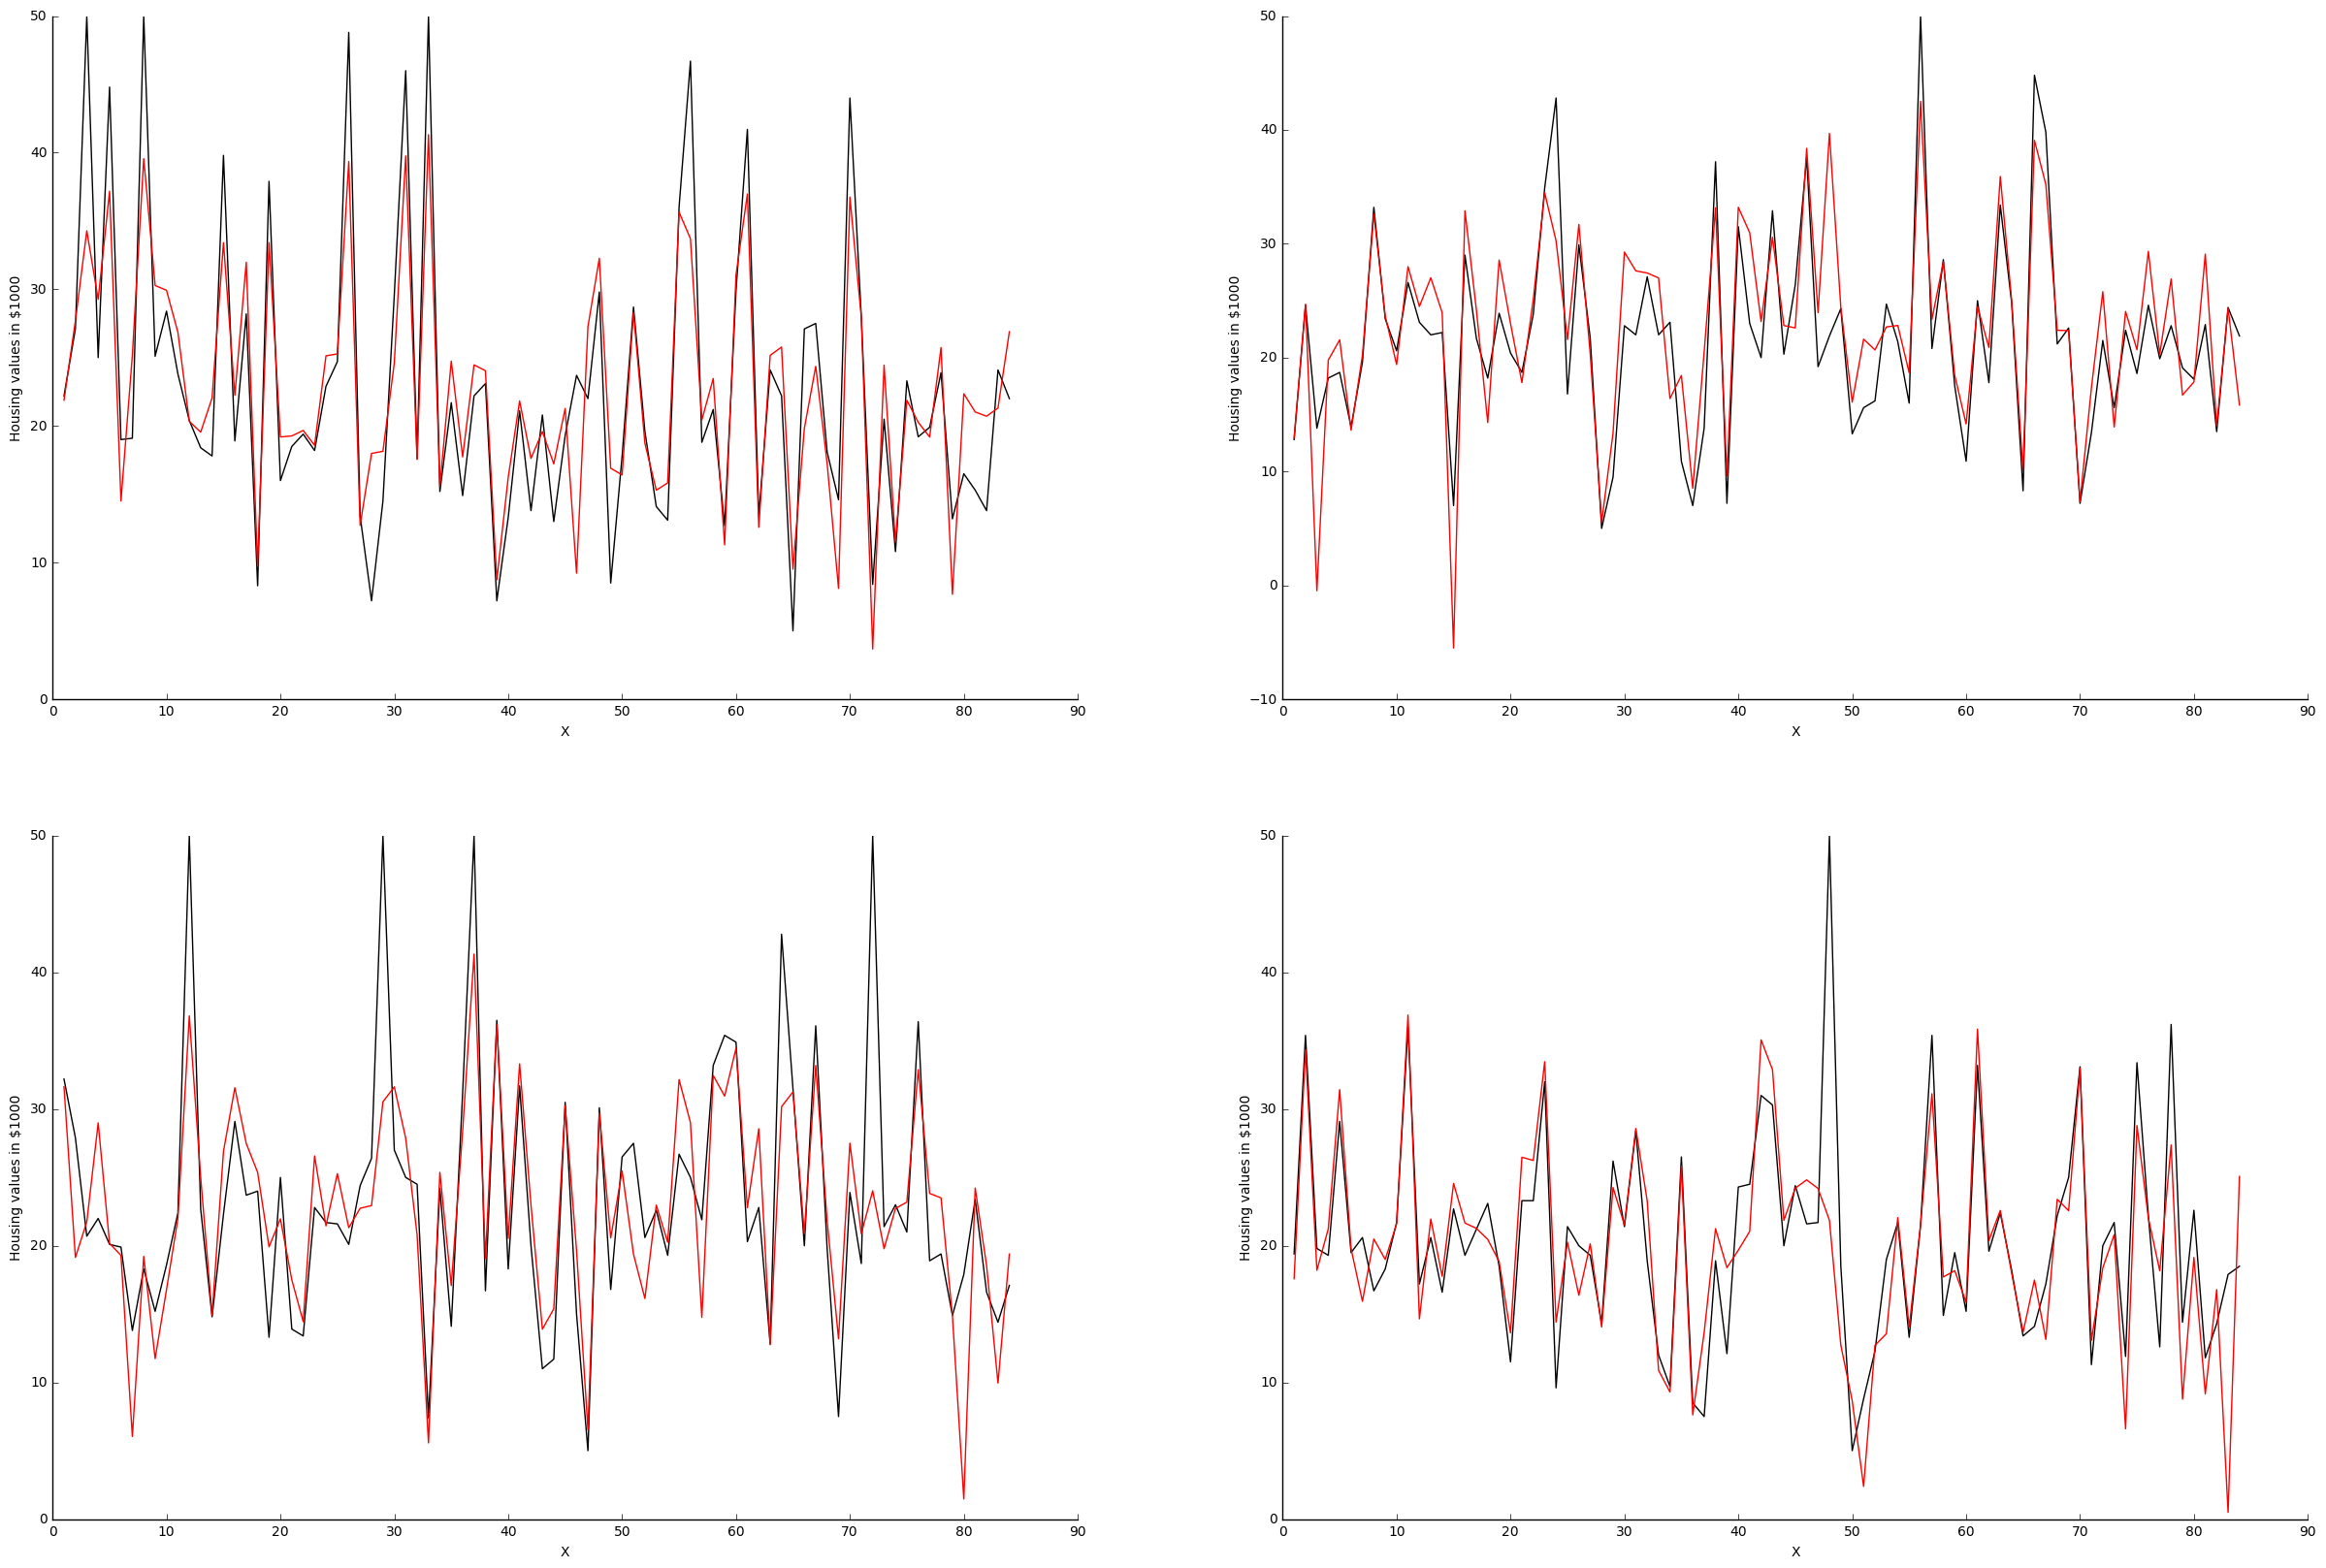

The weights of the predictors:  [(1, -0.6463), (2, 0.7419), (3, 0.255), (4, 0.8737), (5, -1.7614), (6, 2.5439), (7, -0.162), (8, -2.8667), (9, 2.5337), (10, -2.1656), (11, -2.277), (12, 0.8082), (13, -3.7725), (14, 22.665)]


In [12]:
print "The average prediction error of the ridge regression on the validation rounds were: ", np.mean(np.sqrt(MeanRidgeAccuracy))

# plotting the accuracy of the predictions
fig,ax = plt.subplots(2,2, figsize=(30, 20),squeeze=False)
ax = ax.ravel()

plot=0
for i in range(2):
    for j in range(2):
        ax[plot].plot(range(1,all_y_test[:,i,j].shape[0]+1),all_y_test[:,i,j], 'k-')
        ax[plot].plot(range(1,X_test_pred[:,i,j].shape[0]+1),X_test_pred[:,i,j], 'r-')
        ax[plot].spines['right'].set_visible(False)
        ax[plot].spines['top'].set_visible(False)
        ax[plot].xaxis.set_ticks_position('bottom')
        ax[plot].yaxis.set_ticks_position('left')
        ax[plot].set_xlabel('X')
        ax[plot].set_ylabel('Housing values in $1000')
        plot = plot+1
plt.show()

print 'The weights of the predictors: ', zip(range(1,W_RR.shape[0]+1),[round(W_RR[i],4) for i in range(W_RR.shape[0])])

The predictors in the data set:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 (USD)
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    percentage of lower status of the population
    14. MEDV     Median value of owner-occupied homes in 1000 (USD)

#### Bayesian regression results

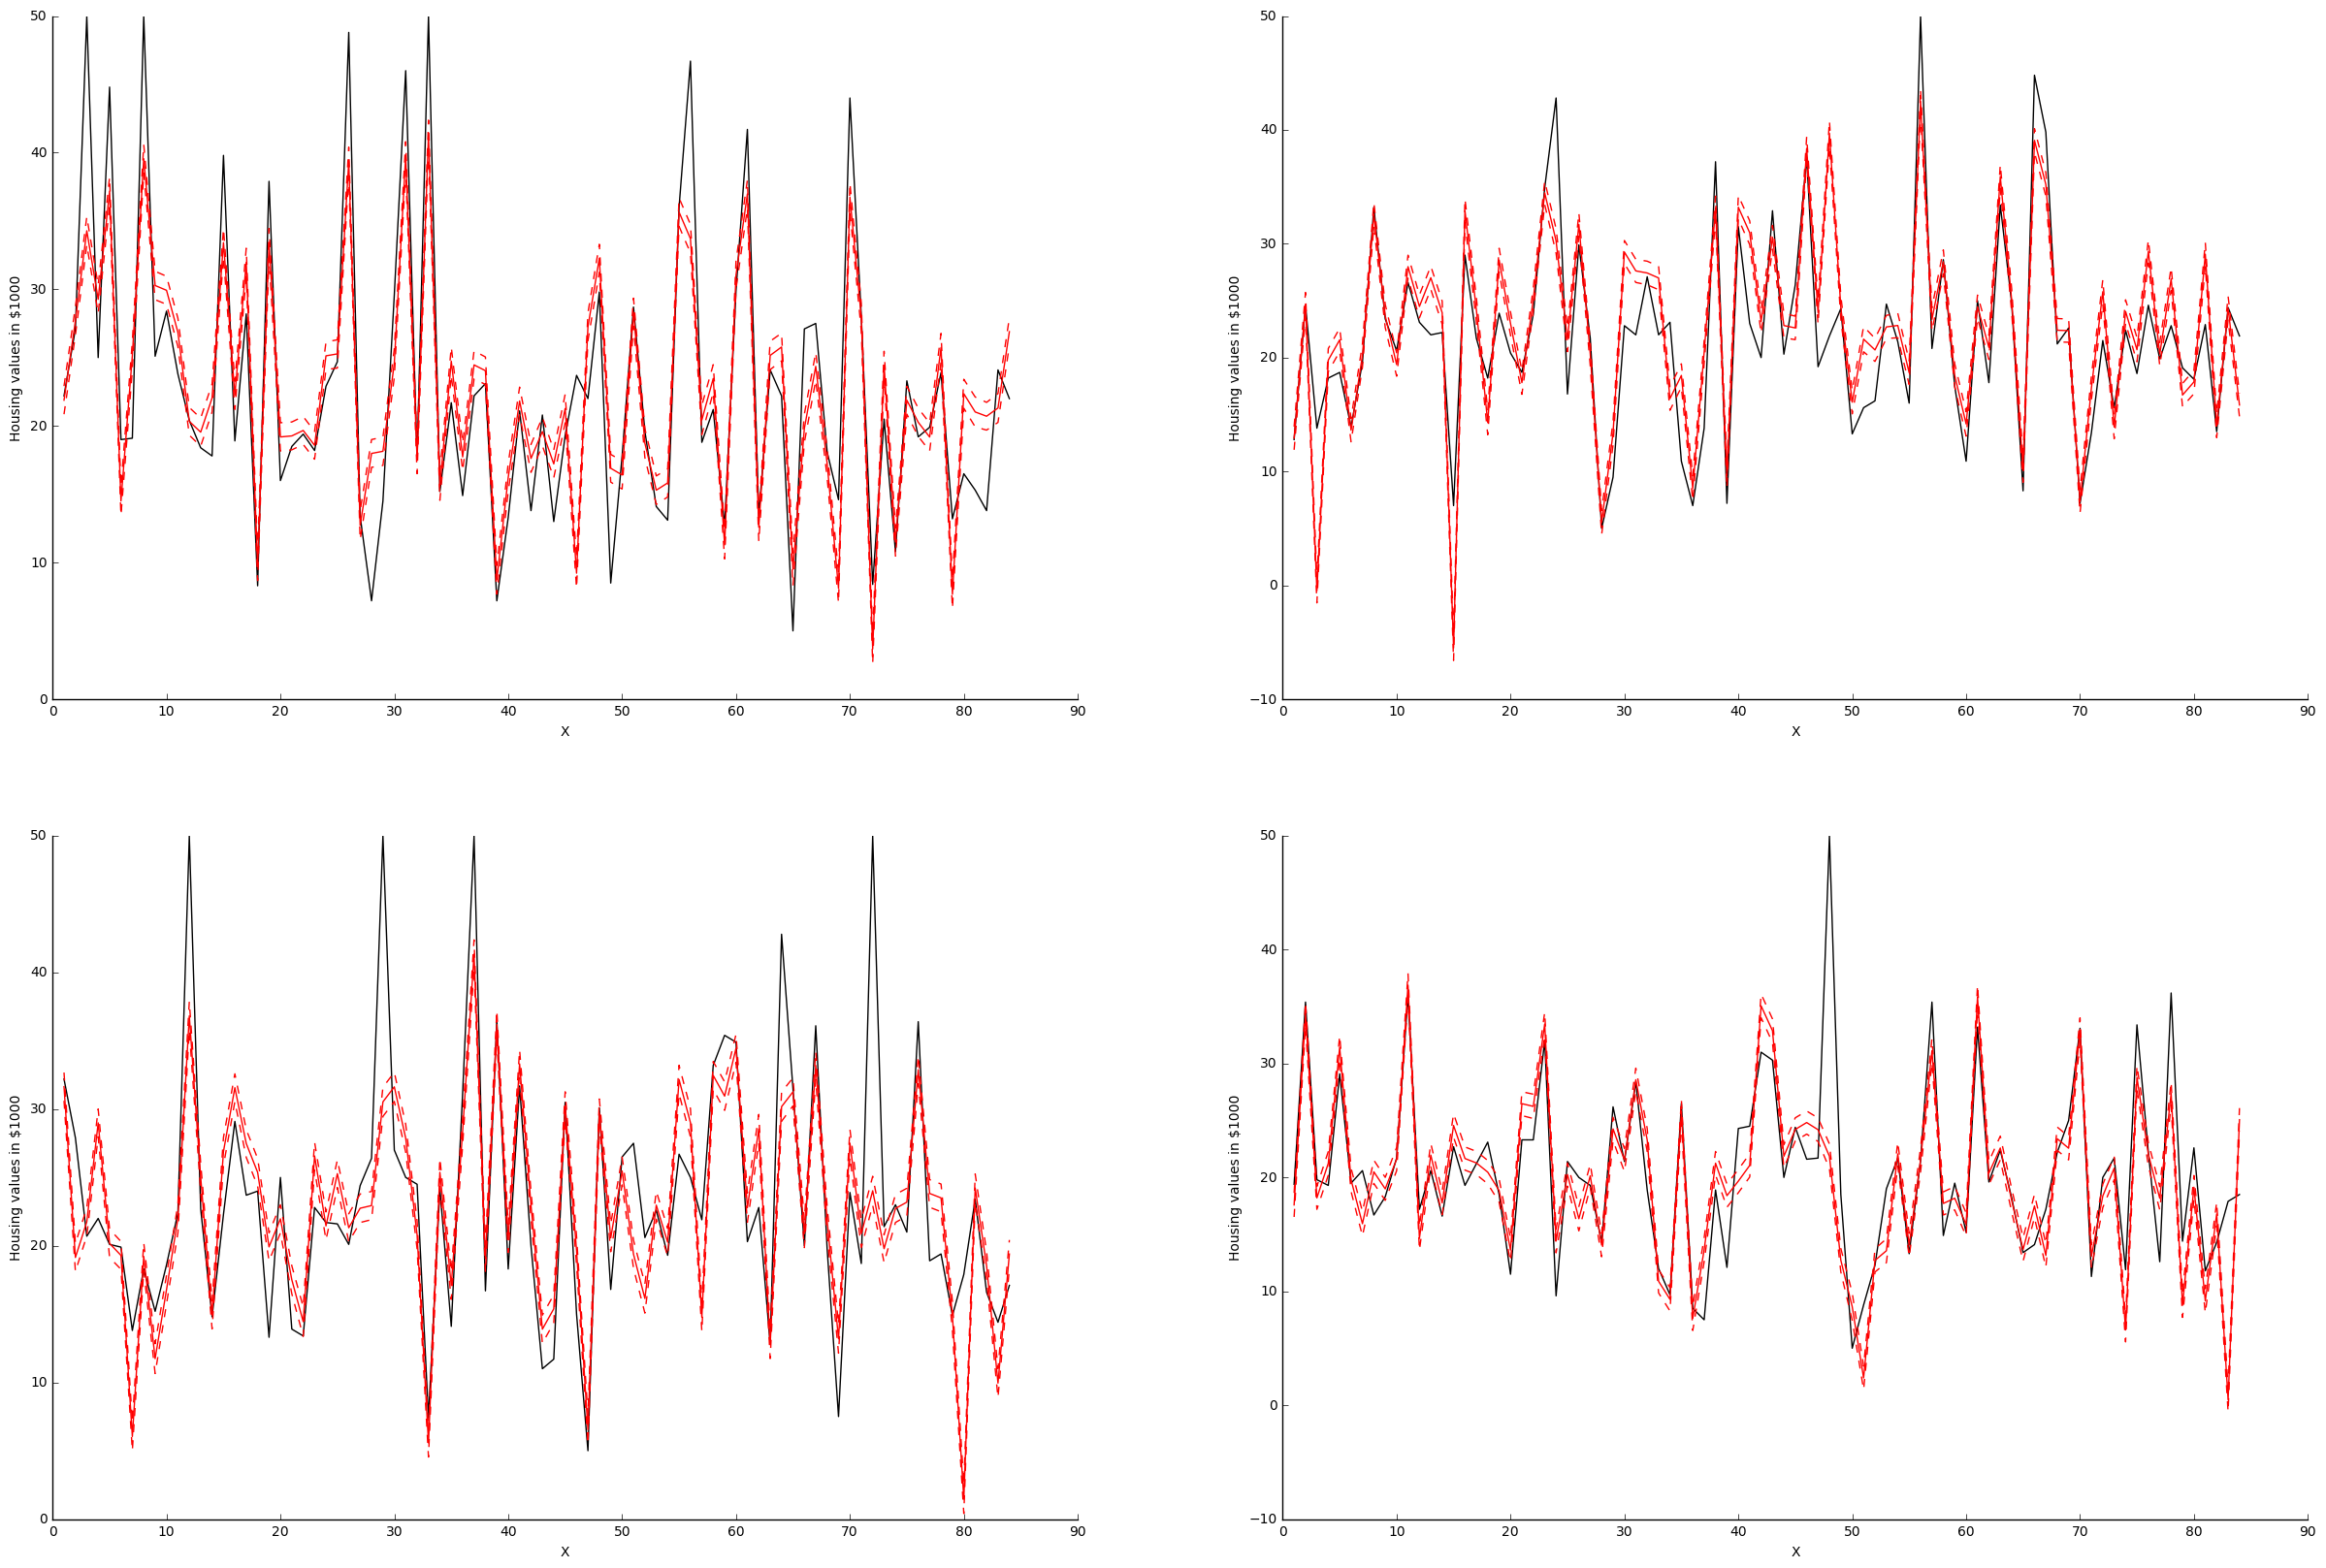

In [13]:
# plotting the accuracy of the predictions
fig,ax = plt.subplots(2,2, figsize=(30, 20),squeeze=False)
ax = ax.ravel()

plot=0
for i in range(2):
    for j in range(2):
        ax[plot].plot(range(1,all_y_test[:,i,j].shape[0]+1),all_y_test[:,i,j], 'k-')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j], 'r-')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j]+Bayes_pred_c[:,i,j], 'r--')
        ax[plot].plot(range(1,Bayes_pred_m[:,i,j].shape[0]+1),Bayes_pred_m[:,i,j]-Bayes_pred_c[:,i,j], 'r--')
        ax[plot].spines['right'].set_visible(False)
        ax[plot].spines['top'].set_visible(False)
        ax[plot].xaxis.set_ticks_position('bottom')
        ax[plot].yaxis.set_ticks_position('left')
        ax[plot].set_xlabel('X')
        ax[plot].set_ylabel('Housing values in $1000')
        plot = plot+1
plt.show()

### Sparse regression

In [16]:
InitW = np.zeros(data.shape[1])
split = 6
examples = data.shape[0]
partition = round(examples/split)
NcrossVal = 3
lmbd = 5
Sgm = 1

Iter = 100000
eta = 0.000006
W = InitW

MeanRidgeAccuracy = np.zeros(NcrossVal)
X_test_pred = np.zeros((partition, split, NcrossVal))
all_y_test = np.zeros((partition, split, NcrossVal))


for crossVal in range(NcrossVal):
    
    print 'Validation round: ', crossVal
    
    # let us train and test our data for each possible partition
    np.random.shuffle(data)

    RidgeSQErr = np.zeros(split)
    
    for i in range(split):
        
        print 'Split NO: ', i
        
        # creating training and test sets
        testidx = np.arange(examples)
        testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
        X_test = data[testidx,0:-1]
        X_test = np.hstack((X_test, np.array([np.ones(X_test.shape[0])]).T)) # adding the bias term
        Y_test = data[testidx,-1]
        X_train = data[np.invert(testidx),0:-1]
        X_train = np.hstack((X_train, np.array([np.ones(X_train.shape[0])]).T)) # adding the bias term
        Y_train = data[np.invert(testidx),-1]
        
        # fitting the training data with max likelihood with the ridge regression
        for step in range(Iter):

            # compute the cost and gradient
            Cost, Grad = SparseRegCostGrad(X_train,Y_train,W,lmbd)
            
            if step>999990:
                print round(Cost,2)

            # Update
            W = W - eta*Grad # full update
            
        W_SR = W
        
        # predicting the test values
        X_test_pred[:,i,crossVal] = np.dot(X_test, W_SR)
        all_y_test[:,i,crossVal] = Y_test
        
        # the accuracy
        RidgeSQErr[i] = np.mean(np.square(Y_test - X_test_pred[:,i,crossVal]))

    MeanRidgeAccuracy[crossVal] = np.mean(RidgeSQErr)

C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 Validation round:  0
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  1
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5
Validation round:  2
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Split NO:  5


The average prediction error of the sparse regression on the validation rounds were:  5.18739775573


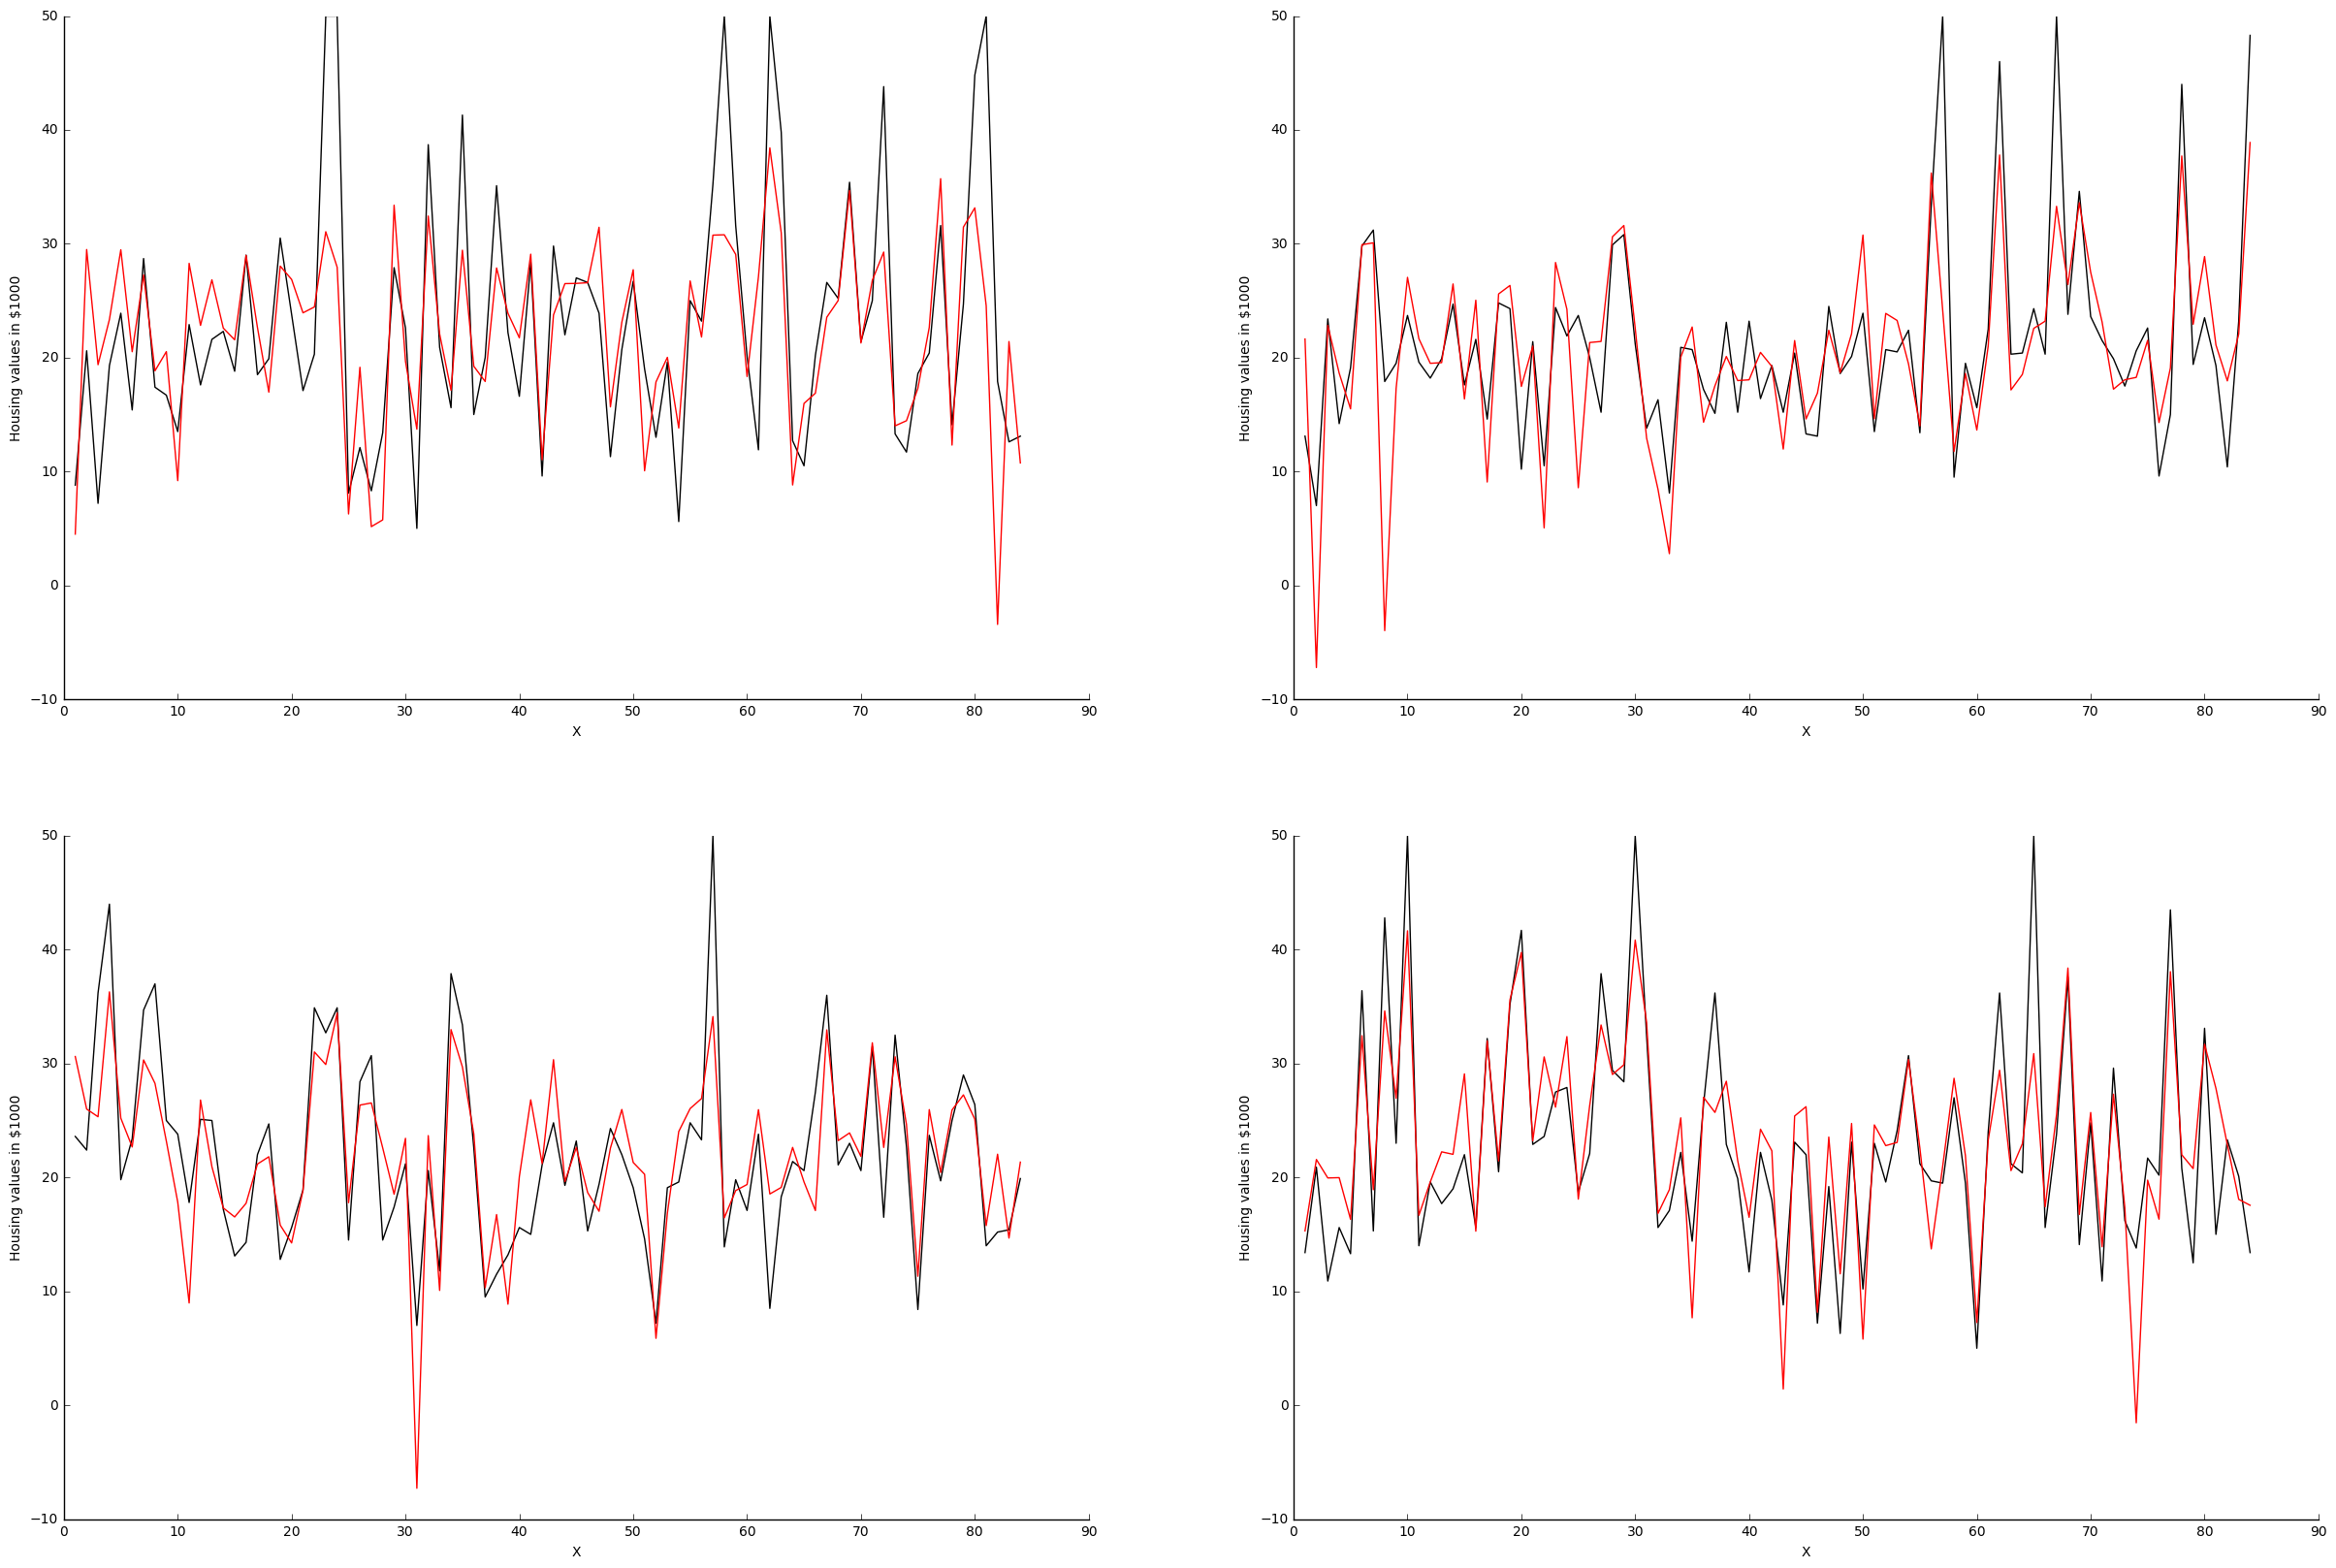

The weights of the predictors:  [(1, -0.1592), (2, 0.0376), (3, -0.007), (4, 1.4729), (5, 0.134), (6, 5.7815), (7, -0.0157), (8, -0.9777), (9, 0.2554), (10, -0.0108), (11, -0.4735), (12, 0.0175), (13, -0.4488), (14, 1.029)]


In [17]:
print "The average prediction error of the sparse regression on the validation rounds were: ", np.mean(np.sqrt(MeanRidgeAccuracy))

# plotting the accuracy of the predictions
fig,ax = plt.subplots(2,2, figsize=(30, 20),squeeze=False)
ax = ax.ravel()

plot=0
for i in range(2):
    for j in range(2):
        ax[plot].plot(range(1,all_y_test[:,i,j].shape[0]+1),all_y_test[:,i,j], 'k-')
        ax[plot].plot(range(1,X_test_pred[:,i,j].shape[0]+1),X_test_pred[:,i,j], 'r-')
        ax[plot].spines['right'].set_visible(False)
        ax[plot].spines['top'].set_visible(False)
        ax[plot].xaxis.set_ticks_position('bottom')
        ax[plot].yaxis.set_ticks_position('left')
        ax[plot].set_xlabel('X')
        ax[plot].set_ylabel('Housing values in $1000')
        plot = plot+1
plt.show()

print 'The weights of the predictors: ', zip(range(1,W_SR.shape[0]+1),[round(W_SR[i],4) for i in range(W_SR.shape[0])])

The predictors in the data set:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 (USD)
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    13. LSTAT    percentage of lower status of the population
    14. MEDV     Median value of owner-occupied homes in 1000 (USD)

# Classification

## Load the data

In [18]:
# load data
X1 = np.loadtxt('mnist_train.csv', delimiter=',')
X2 = np.loadtxt('mnist_test.csv', delimiter=',')
print X1.shape
print X2.shape
data = np.vstack((X1,X2))
print data.shape
np.random.shuffle(data)
data=data[0:10000,:]
print data.shape

(60000L, 785L)
(10000L, 785L)
(70000L, 785L)
(10000L, 785L)


### Look at the data

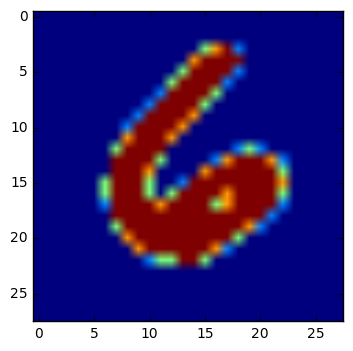

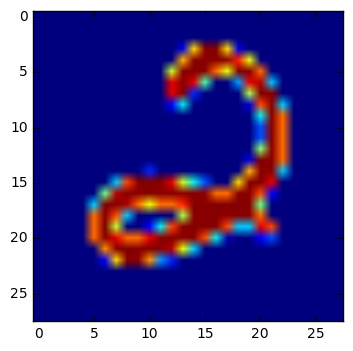

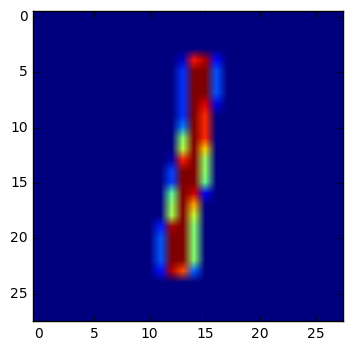

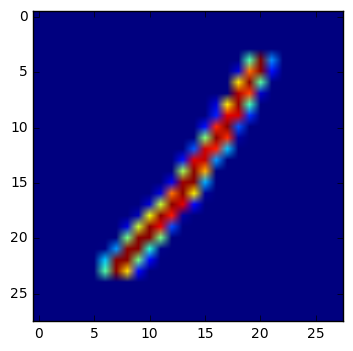

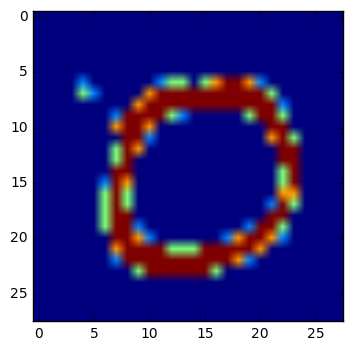

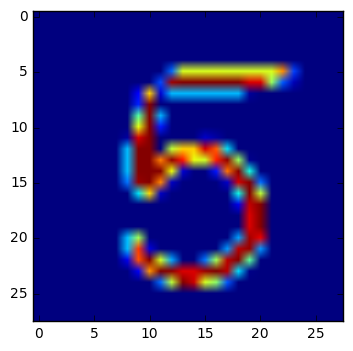

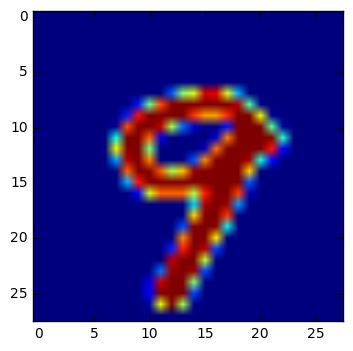

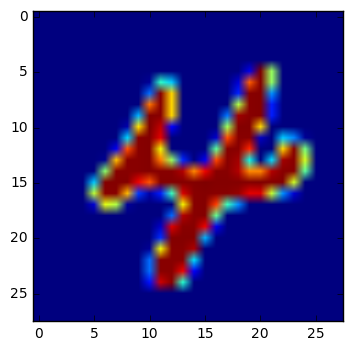

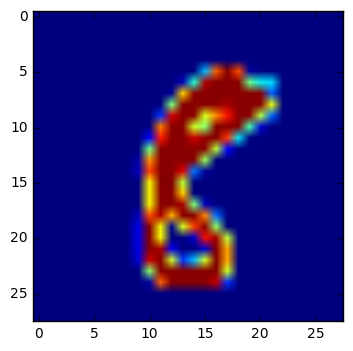

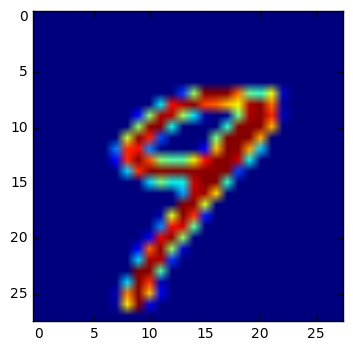

In [19]:
# look at the mean of the features
def create_2D_image(x,w,h):
    
    reshape_data = x.reshape(w, h)
    row, col = reshape_data.shape
    plt.imshow(reshape_data)

np.random.shuffle(data)
for i in range(10):
    create_2D_image(data[i,1:],w=28, h=28)
    plt.show()

## K Nearest neighbors

### Define the distance function

In [20]:
# compute the Euclidean distance between two vector
def EucliDist(u,v):
    
    Diff = (u-v)
    dist = np.sqrt(np.dot(Diff,Diff))
        
    return dist

u = np.array([1,3,7])
v = np.array([1,4,5])
EucliDist(u,v)

2.2360679774997898

### The K nearest neighbors algorithm with cross validation

In [22]:
split = 5
examples = data.shape[0]
partition = round(examples/split)
Ksmallest = 5
NcrossVal = 1

# let us pick the best k in 10
GrandMeanAccuracy = np.zeros(Ksmallest)
for k in range(Ksmallest):
    k = k+1
    
    MeanAccuracy = np.zeros(NcrossVal)
    for crossVal in range(NcrossVal):
        
        print 'Validation round: ', crossVal
        
        # let us train and test our data for each possible partition
        np.random.shuffle(data)

        accuracy = np.zeros(split)

        for i in range(split):
            
            print 'Splitting: ', i
            
            # creating training and test sets
            testidx = np.arange(examples)
            testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
            X_test = data[testidx,0:-1]
            Y_test = data[testidx, -1]
            X_train = data[np.invert(testidx),0:-1]
            Y_train = data[np.invert(testidx),-1]

            # compute the distance between the test data and each datapoint and pick the smallest
            #KmallestDistances = np.zeros((X_test.shape[0],k))
            KsmallestIdx = np.zeros((X_test.shape[0],k))
            for testPoint in range(X_test.shape[0]):
                
                #print 'Testpoint NO: ', testPoint
                
                dist = np.zeros(X_train.shape[0])
                for trainingPoint in range(X_train.shape[0]):
                    dist[trainingPoint] = EucliDist(X_test[testPoint,:],X_train[trainingPoint,:])

                KsmallestIdx[testPoint,:] = np.argsort(dist)[0:k]
                #KSmallestDistances[testPoint,:] = np.sort(dist)[0:k]

            X_test_pred = [np.array(Y_train[list(KsmallestIdx[j,:])]) for j in range(KsmallestIdx.shape[0])]
            X_test_pred = sc.mode(X_test_pred, axis=1)

            accuracy[i] = np.mean(Y_test == list(X_test_pred)[0].T)

        MeanAccuracy[crossVal] = np.mean(accuracy)
        
    GrandMeanAccuracy[k-1] = np.mean(MeanAccuracy)

Validation round:  0
Splitting:  0


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


Splitting:  1
Splitting:  2
Splitting:  3
Splitting:  4
Validation round:  0
Splitting:  0
Splitting:  1
Splitting:  2
Splitting:  3
Splitting:  4
Validation round:  0
Splitting:  0
Splitting:  1
Splitting:  2
Splitting:  3
Splitting:  4
Validation round:  0
Splitting:  0
Splitting:  1
Splitting:  2
Splitting:  3
Splitting:  4
Validation round:  0
Splitting:  0
Splitting:  1
Splitting:  2
Splitting:  3
Splitting:  4


### Results

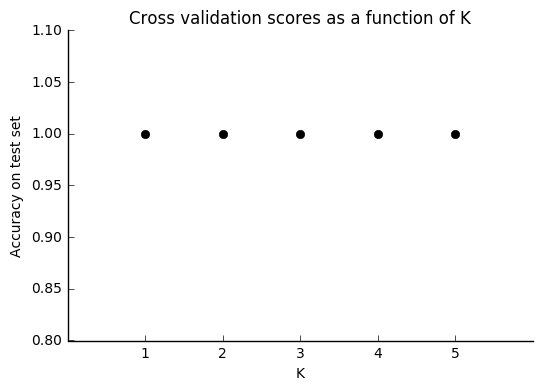

In [24]:
# plotting the accuracy as a function of K
fig,ax = plt.subplots(1,1)
ax.plot(range(1,Ksmallest+1),GrandMeanAccuracy, 'ko')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks(range(1,Ksmallest+1))
ax.set_xlim([0, Ksmallest+1])
ax.set_ylim([0.8,1.1])
ax.set_xlabel('K')
ax.set_ylabel('Accuracy on test set')
plt.title('Cross validation scores as a function of K')
plt.show()

### Missclassified images

In [27]:
pred = (Y_test == list(X_test_pred)[0].T)
miss = [i for i,j in enumerate(pred[0]) if j==0]

for i in miss:
    create_2D_image(X[i,0:-1],w=28, h=28)
    plt.show()

## Bayes classifier

### The model

If we assume, and know a joint distribution over the predictors and the labels: $ (X,Y) \sim P $ and the data is IID, then the Bayes classifier is the optimal way to classify the data.

For the classifier function $f: X->y$ the Bayes classifier: 

$f(x) = \arg\max_{y \in Y} P(Y=y~|~X=x)
= \arg\max_{y \in Y} P(X=x~|~Y=y)P(Y=y)$

Because we do not know the distributions, from which our data was generated, first we have to assume a particular family of distributions that underlies our data, second we have to estimate its paramters from the data.

### Defining functions

In [28]:
# prior probability of the classes
def ClassPrior(Y):
    
    N = Y.shape[0]
    
    sortedY = np.sort(Y)

    Classes = [sortedY[i] for i in range(N) if sortedY[i]!=sortedY[i-1]]

    ProbofClass = [np.sum(Y == Class)/float(N) for Class in Classes]
        
    return np.array(ProbofClass)

prior = ClassPrior(data[:,0])


# The class conditional density is a gaussian so let us estimate that. Note that the features are independent from each other, at least we assume that in the naive bayes
def ClassCondDensityParam(X,Y):
    
    N = Y.shape[0]
    sortedY = np.sort(Y)
    Classes = [sortedY[i] for i in range(N) if sortedY[i]!=sortedY[i-1]]
    NClasses = len(Classes)
    NFeatures = X.shape[1]
    
    Mean = np.zeros((NClasses, NFeatures))
    Covar = np.zeros((NClasses, NFeatures))
    
    for Class in Classes:
        
        idx = (Y == Class)
        x = X[idx,:]

        Mean[Class-1,:] = np.mean(x, axis = 0)

        SqrDevFromMean = np.square(x-Mean[Class-1,:])
        SumSqrDevFromMean = np.sum(SqrDevFromMean, axis = 0)
        Covar[Class-1,:] = np.divide(SumSqrDevFromMean,float(x.shape[0]))

    return Mean, Covar

Mean, Covar = ClassCondDensityParam(data[:,1:],data[:,0])


# LogNormalDensity assuming non corralted predictors/variables
def LogClassCondDensityNormal(X, mean, var):
    
    sd = np.sqrt(var)
    NormTerm =  1.0/(sd*np.sqrt(2*np.pi))
    
    SqrDevFromMean = np.square(X-mean)
    ExpTerm = np.exp(-(SqrDevFromMean/(2*var)))
    
    density = NormTerm*ExpTerm
    
    logDensity = np.log(density)
    
    return np.sum(logDensity)


# Plug in classifier: computes the probability of belonging to a class
def predOfClass(prior, X, Mu, Cov):
    
    N = X.shape[0]
    F = X.shape[1]
    C = Mu.shape[0]
    
    PredictedClass = np.zeros((N,C))

    for points in range(N):
        
        PredictedAllClass = np.zeros(C)
        
        for Class in range(C):
            
            PredictedAllClass[Class] = np.log(prior[Class]) + LogClassCondDensityNormal(X[points,:], Mu[Class,:], Cov[Class,:]+1) # sc.multivariate_normal.pdf(X[points,:], Mu[Class,:], np.diag(Cov[Class,:]+0.00000001))
            
        PredictedClass[points,:] =   PredictedAllClass
        
    PredictedClass = np.argmax(PredictedClass, axis = 1)
    
    indxof10 = PredictedClass == 9
    PredictedClass[indxof10] = -1
    
    return PredictedClass+1

C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Visualize the estimated parameters of the class conditional distribution

##### The mean

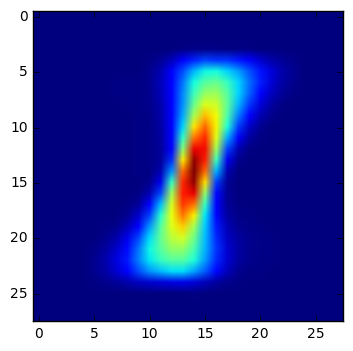

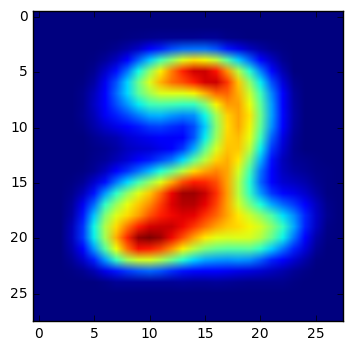

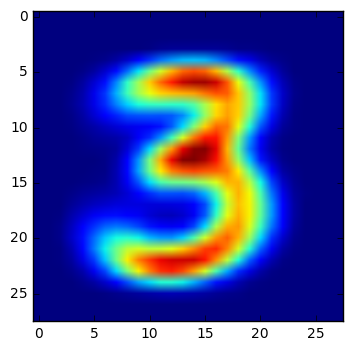

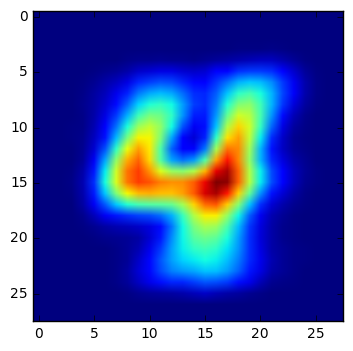

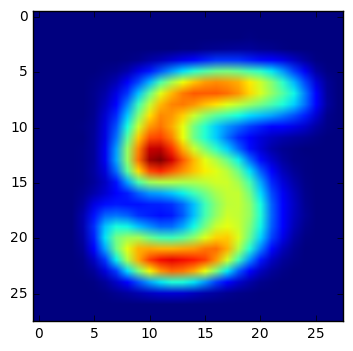

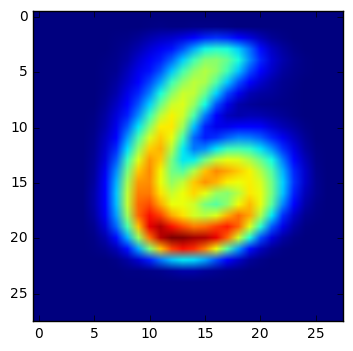

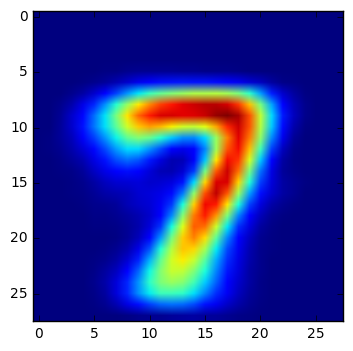

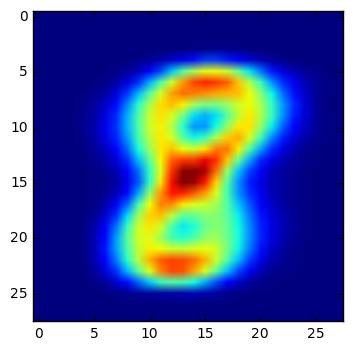

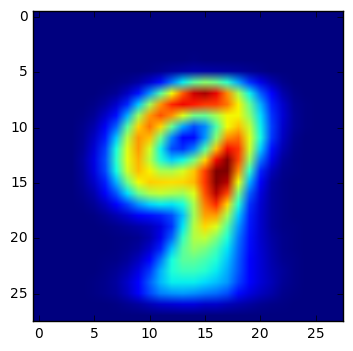

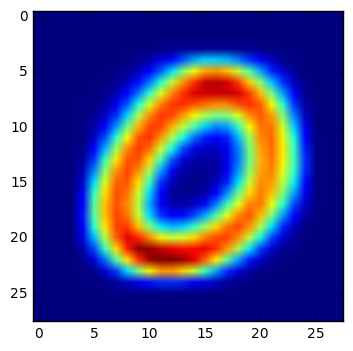

In [29]:
for i in range(10):
    create_2D_image(Mean[i,:],w=28, h=28)
    plt.show()

##### The variance

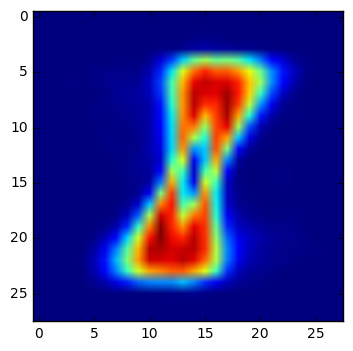

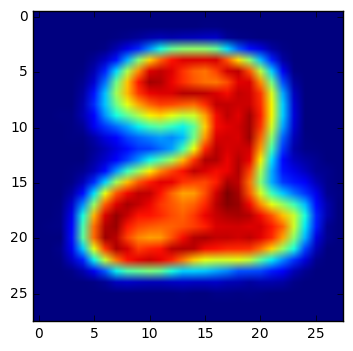

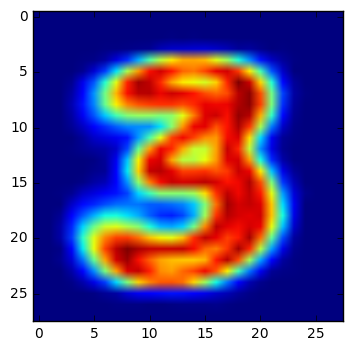

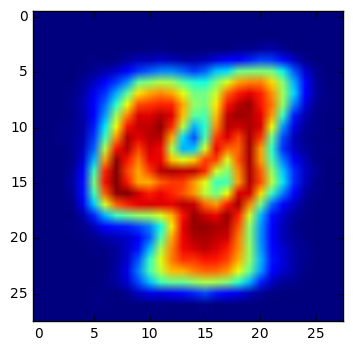

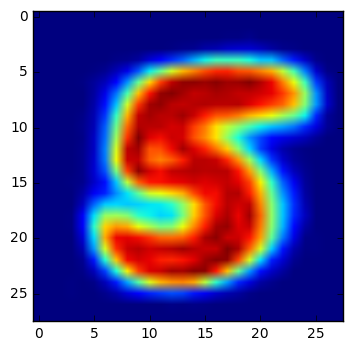

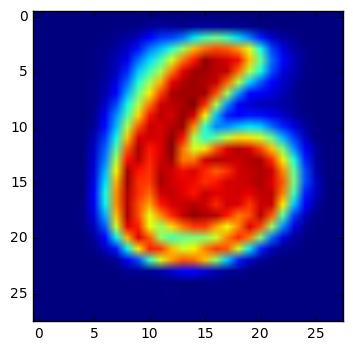

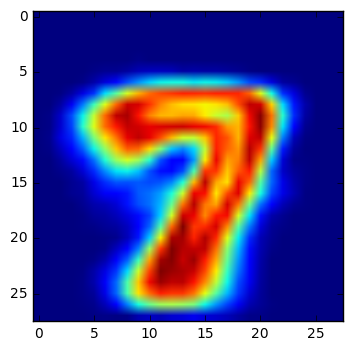

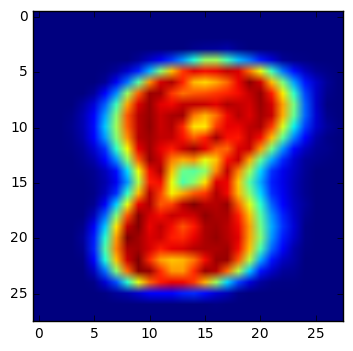

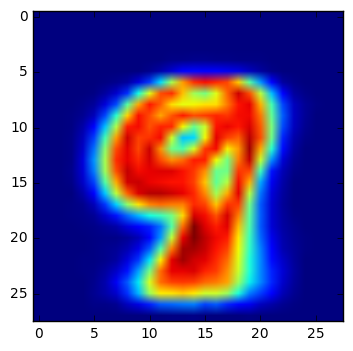

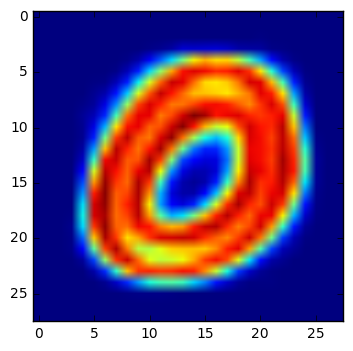

In [30]:
for i in range(10):
    create_2D_image(Covar[i,:],w=28, h=28)
    plt.show()

### Testing the accuracy of the Bayes classifier with cross validation

In [31]:
split = 5
examples = data.shape[0]
partition = round(examples/split)
NcrossVal = 4

MeanAccuracy = np.zeros(NcrossVal)
for crossVal in range(NcrossVal):
    
    print 'Validation round: ', crossVal
    
    # let us train and test our data for each possible partition
    np.random.shuffle(data)

    accuracy = np.zeros(split)

    for i in range(split):
        
        print 'Split NO: ', i
        
        # creating training and test sets
        testidx = np.arange(examples)
        testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
        X_test = data[testidx,1:]
        Y_test = data[testidx, 0]
        X_train = data[np.invert(testidx),1:]
        Y_train = data[np.invert(testidx),0]

        # Compute prior
        ClPrior = ClassPrior(Y_train)

        # Compute Likelihood, the Class Conditional Density
        mean, var = ClassCondDensityParam(X_train,Y_train)

        # plug in classifier
        X_test_pred = predOfClass(ClPrior, X_test, mean, var)

        # the accuracy
        accuracy[i] = np.mean(Y_test == X_test_pred)

    MeanAccuracy[crossVal] = np.mean(accuracy)
    
print "Accuracy of the validation rounds: ", MeanAccuracy

Validation round:  0
Split NO:  0


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log


Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  1
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  2
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  3
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Accuracy of the validation rounds:  [ 0.7078  0.7058  0.7048  0.7055]


### Testing the accuracy of the Bayes classifier with Normalized predictors

In [32]:
# I also add a small constant to all pixel to avoid division with zero
def FeatureNormalize(X):
    Mean = np.mean(X, axis = 0)
    STD = np.std(X, axis = 0)
    X_norm = (X-Mean)/(STD+0.000001)
    
    return X_norm, Mean, STD

X, Mean, STD = FeatureNormalize(data[:,1:])
print X.shape, Mean.shape, STD.shape

mean, Covar = ClassCondDensityParam(X,data[:,0])

(10000L, 784L) (784L,) (784L,)


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Visualize the estimated parameters of the class conditional distribution

##### The mean

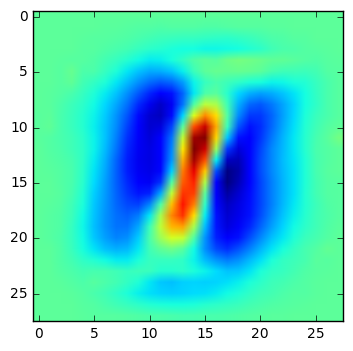

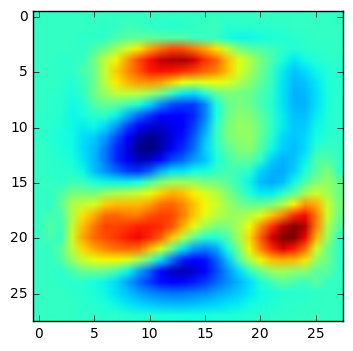

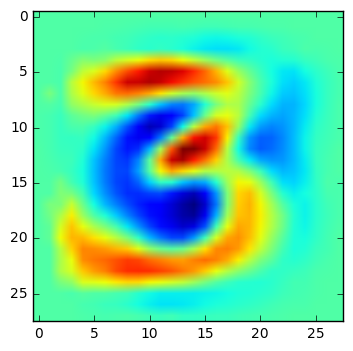

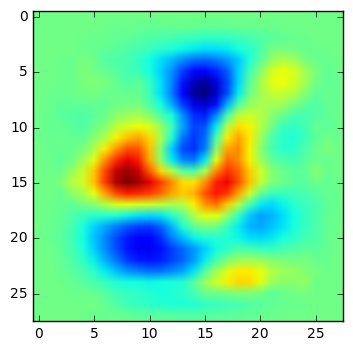

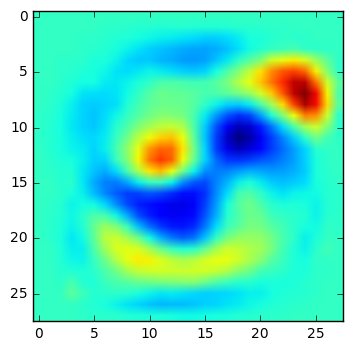

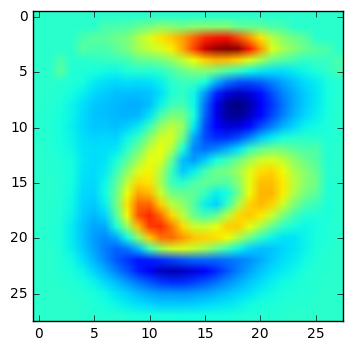

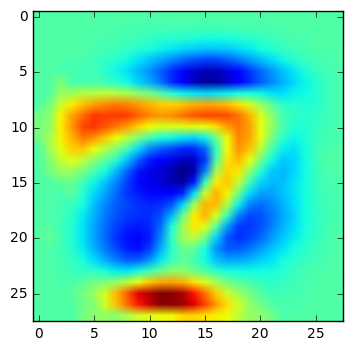

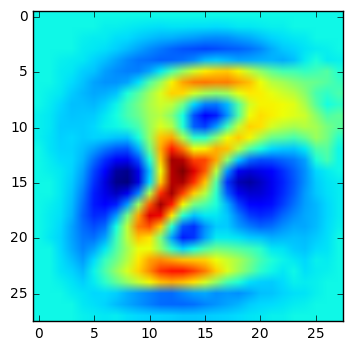

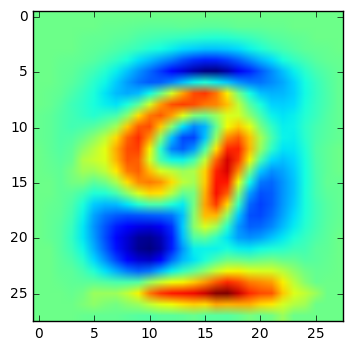

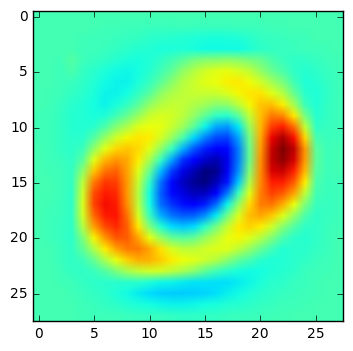

In [33]:
for i in range(10):
    create_2D_image(mean[i,:],w=28, h=28)
    plt.show()

##### The Variance

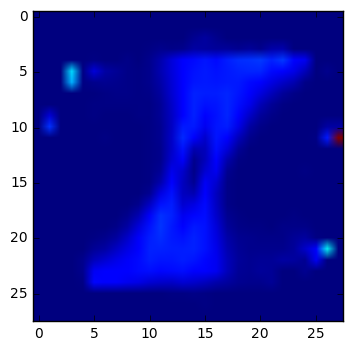

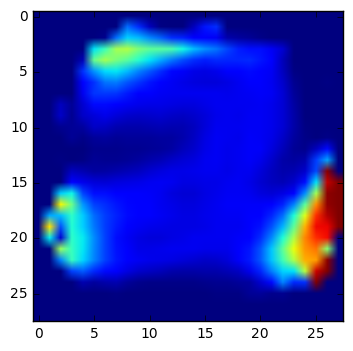

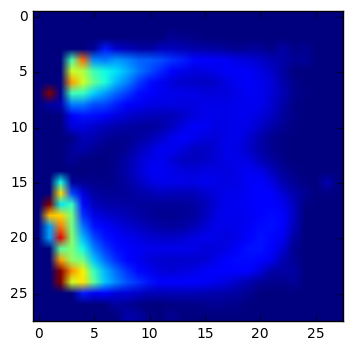

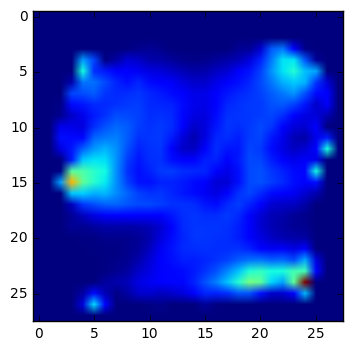

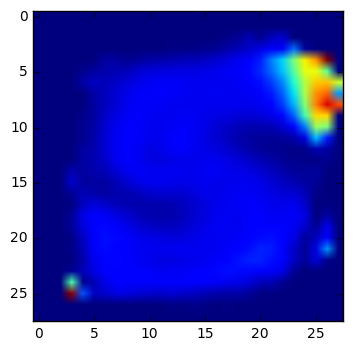

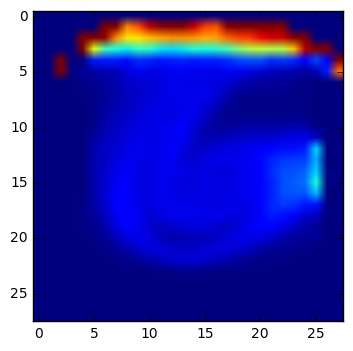

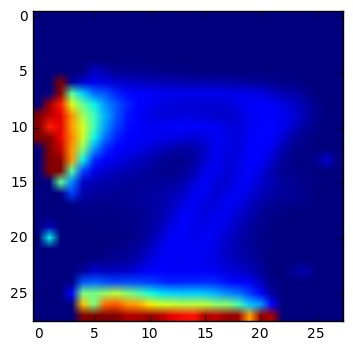

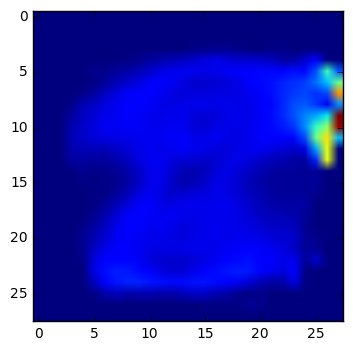

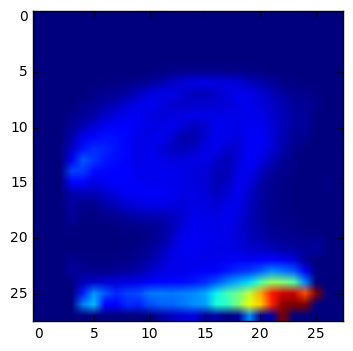

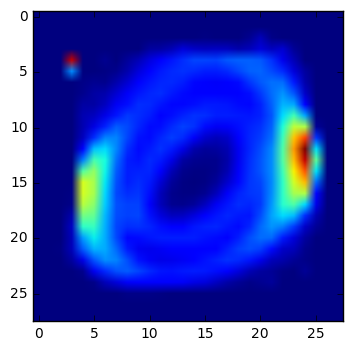

In [34]:
for i in range(10):
    create_2D_image(Covar[i,:],w=28, h=28)
    plt.show()

In [35]:
NormData = np.vstack((X.T,data[:,0])).T
print NormData.shape 

split = 5
examples = NormData.shape[0]
partition = round(examples/split)
NcrossVal = 4

MeanAccuracy = np.zeros(NcrossVal)
for crossVal in range(NcrossVal):
    
    print 'Validation round: ', crossVal
    
    # let us train and test our data for each possible partition
    np.random.shuffle(NormData)

    accuracy = np.zeros(split)

    for i in range(split):
        
        print 'Split NO: ', i
        
        # creating training and test sets
        testidx = np.arange(examples)
        testidx =(testidx[:]>=i*partition) & (testidx[:]<(i+1)*partition)
        X_test = NormData[testidx,0:-1]
        Y_test = NormData[testidx, -1]
        X_train = NormData[np.invert(testidx),0:-1]
        Y_train = NormData[np.invert(testidx),-1]

        # Compute prior
        ClPrior = ClassPrior(Y_train)

        # Compute Likelihood, the Class Conditional Density
        mean, var = ClassCondDensityParam(X_train,Y_train)

        # plug in classifier
        X_test_pred = predOfClass(ClPrior, X_test, mean, np.ones((mean.shape[0], mean.shape[1])))

        # the accuracy
        accuracy[i] = np.mean(Y_test == X_test_pred)

    MeanAccuracy[crossVal] = np.mean(accuracy)
    
print "Accuracy of the validation rounds: ", MeanAccuracy

(10000L, 785L)
Validation round:  0
Split NO:  0


C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\sajtk\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log


Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  1
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  2
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Validation round:  3
Split NO:  0
Split NO:  1
Split NO:  2
Split NO:  3
Split NO:  4
Accuracy of the validation rounds:  [ 0.7912  0.7899  0.7916  0.7921]


### Missclassified images

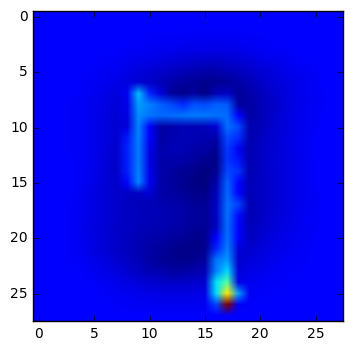

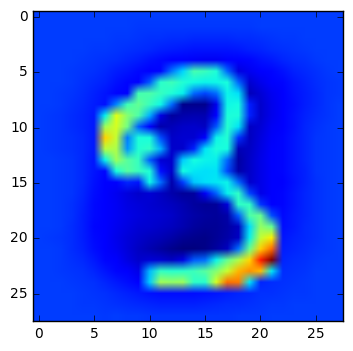

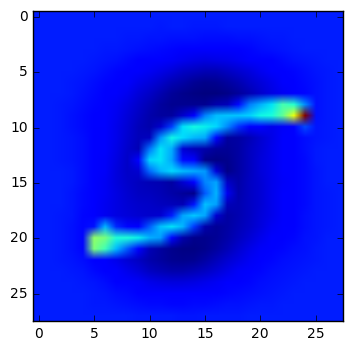

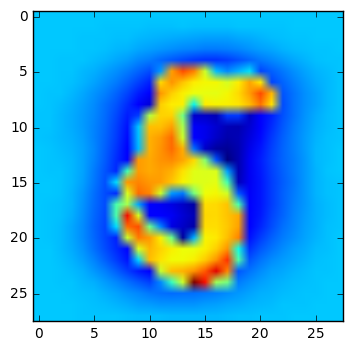

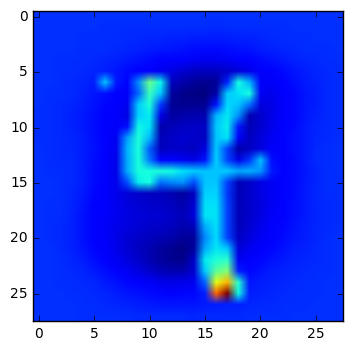

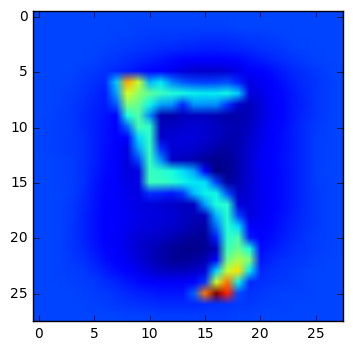

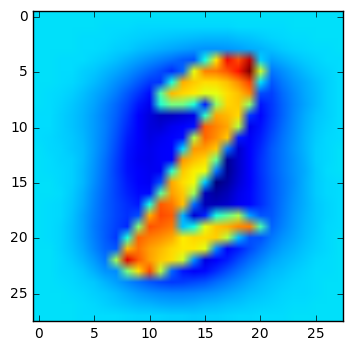

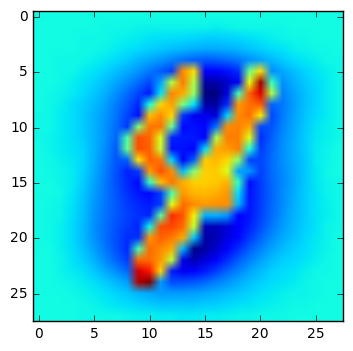

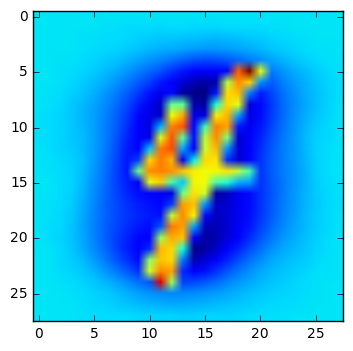

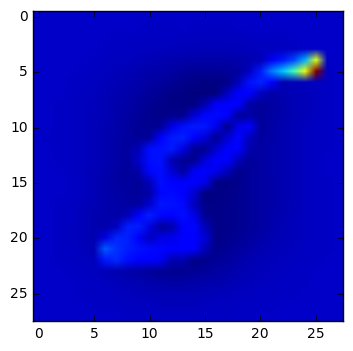

In [39]:
pred = (Y_test == X_test_pred)
miss = [i for i,j in enumerate(pred) if j==0]

for i in miss[10:20]:
    create_2D_image(X_test[i,:],w=28, h=28)
    plt.show()

# Binary Classification

## Perceptron

### The model

For the classifier function $f: X->y$ the Bayes classifier: 

$f(x) = sign(Xw)$


$ w_{opt} = \arg\min_{w} \sum_n (y_n x_n^{T} w) * I\{y_n \neq sign(x_n^{T}w)\} $


### The data

In [40]:
# we choose just two category. Here the digit one and 3
dataS = data[(data[:,0] == 1) | (data[:,0] == 3)]
print dataS.shape
print dataS[(dataS[:,0] == 1)].shape

# subtract of the mean, because in the perceptron there is no bias/ intercept term
np.random.shuffle(dataS)
X = dataS[:,1:]
Y = dataS[:,0]-2
Mean = np.mean(X, axis = 0)
X_norm = X-Mean


(2067L, 785L)
(1073L, 785L)


### Defining the function

In [41]:
# The cost function
# Summing all the predictions that we did it wrong
def PerceptronCost(X,Y,W):
    
    DotProduct = np.dot(X,W)
    IdxOfWrong = np.sign(DotProduct) == Y
    
    Cost = np.dot(X[np.invert(IdxOfWrong),:],W) * Y[np.invert(IdxOfWrong)]
    Cost = -np.sum(Cost)
    
    Grad = X[np.invert(IdxOfWrong),:].T * Y[np.invert(IdxOfWrong)]
    Grad = -np.sum(Grad.T, axis=0)
    
    return Cost, Grad



### Testing the model by fitting the parameter with gradient descent

In [42]:
# gradient descent
InitW = np.zeros(X.shape[1])
Iter = 1000
eta = 0.1
W = InitW
for step in range(Iter):
    
    print step
    
    # compute the cost and gradient
    Cost, Grad = PerceptronCost(X_norm,Y,W)
    
    print round(Cost)
    
    # Update
    W = W - eta*Grad # full update
    
accuracy = np.mean(np.sign(np.dot(X_norm,W)) == Y)

print 'The accuracy of the perceptron: ', accuracy

0
-0.0
1
1234589813.0
2
1193232439.0
3
1155855750.0
4
1120686173.0
5
1085894973.0
6
1051689578.0
7
1019351439.0
8
987566184.0
9
957672686.0
10
928878234.0
11
900451022.0
12
872166988.0
13
845112403.0
14
820320348.0
15
798669992.0
16
778318479.0
17
757974741.0
18
738681677.0
19
719590666.0
20
700551736.0
21
681565082.0
22
662574598.0
23
643530593.0
24
624733583.0
25
607610854.0
26
592519405.0
27
577546737.0
28
562574069.0
29
547601401.0
30
532918923.0
31
518698137.0
32
504584073.0
33
490615033.0
34
476899533.0
35
464059423.0
36
451355992.0
37
438975196.0
38
427700090.0
39
416483629.0
40
405267338.0
41
394094981.0
42
382959894.0
43
372140207.0
44
361708454.0
45
351413019.0
46
341092206.0
47
330867599.0
48
321477545.0
49
313214856.0
50
305004781.0
51
296891272.0
52
288729424.0
53
281300065.0
54
273923575.0
55
266423850.0
56
258981458.0
57
251358865.0
58
244022843.0
59
236579198.0
60
229305651.0
61
221825523.0
62
215802110.0
63
210318341.0
64
204895188.0
65
199475544.0
66
194030181.0
67
18

## Logistic regression

### The model

The logistic link function:

$ \log \frac{P(y=+1~|~x)}{P(y=-1~|~x)} = x^{T}w + w_0 $

If we solve for $P(y=+1~|~x)$, then

$ P(y=+1~|~x) = \frac{exp(x^{T}w + w_0)}{1+exp(x^{T}w + w_0)} = sigmoid(x^{T}w + w_0) $

The maximum likelihood solution:

$
w_{opt} = \arg\max_{w} \sum_n \log sigmoid(x^{T}w + w_0)
$

### The data

In [43]:
X = np.hstack((X, np.array([np.ones(X.shape[0])]).T))

### Defining the function

In [44]:
# cost and gradient function

def LogRegCostGrad(X,Y,W,lmbd):
    
    N = X.shape[0]
    
    # Sigmoid y,w
    DotProduct = np.dot(X,W)
    yTimesDotProd = Y*DotProduct
    Exp = np.exp(yTimesDotProd)
    Sigm = (Exp)/(1+Exp)
    LogSigm = np.log(Sigm)
    reg = (lmbd/2.0)*np.dot(W,W) * N
    
    #cost
    Cost = -(np.sum(LogSigm)-reg)

    # gradient
    oneMinusSigm = 1-Sigm
    xTimesy = X.T * Y
    regGrad = 2*lmbd*W
    
    Grad = xTimesy * oneMinusSigm + np.sum(regGrad/N)
    Grad[-1] = xTimesy[-1,:] * oneMinusSigm[-1] # we do not regularize the bias term
    Grad = -np.sum((1.0/N)*Grad.T, axis=0) 

    return Cost, Grad

### Testing the model by fitting the parameter with gradient descent

In [45]:
# gradient descent
InitW = np.zeros(X.shape[1])
Iter = 2000
eta = 0.000005
W = InitW
lmbda = 1
for step in range(Iter):
    
    print step
    
    # compute the cost and gradient
    Cost, Grad = LogRegCostGrad(X,Y,W,lmbda)
    
    print round(Cost,2)
    
    # Update
    W = W - eta*Grad # full update

Dot = np.dot(X,W)
Exp = np.exp(Dot)
Sigm = (Exp)/(1+Exp)
one = Sigm<0.5
accuracy = np.mean(Y[one] == -1)

print 'The accuracy of the logistic regression: ', accuracy

0
1432.74
1
755.25
2
544.1
3
422.0
4
354.2
5
316.92
6
290.01
7
269.16
8
252.43
9
238.66
10
227.09
11
217.2
12
208.63
13
201.12
14
194.47
15
188.53
16
183.18
17
178.34
18
173.94
19
169.9
20
166.19
21
162.76
22
159.58
23
156.62
24
153.86
25
151.28
26
148.85
27
146.56
28
144.41
29
142.37
30
140.44
31
138.61
32
136.87
33
135.21
34
133.63
35
132.12
36
130.68
37
129.29
38
127.97
39
126.69
40
125.46
41
124.29
42
123.15
43
122.05
44
121.0
45
119.97
46
118.99
47
118.03
48
117.1
49
116.21
50
115.34
51
114.49
52
113.67
53
112.87
54
112.1
55
111.34
56
110.61
57
109.89
58
109.2
59
108.52
60
107.85
61
107.2
62
106.57
63
105.95
64
105.35
65
104.76
66
104.18
67
103.61
68
103.06
69
102.52
70
101.99
71
101.46
72
100.95
73
100.45
74
99.96
75
99.48
76
99.01
77
98.54
78
98.08
79
97.64
80
97.19
81
96.76
82
96.33
83
95.91
84
95.5
85
95.1
86
94.7
87
94.3
88
93.92
89
93.53
90
93.16
91
92.79
92
92.42
93
92.06
94
91.71
95
91.36
96
91.01
97
90.67
98
90.34
99
90.01
100
89.68
101
89.36
102
89.04
103
88.72
104
88.41

### Missclassified pictures

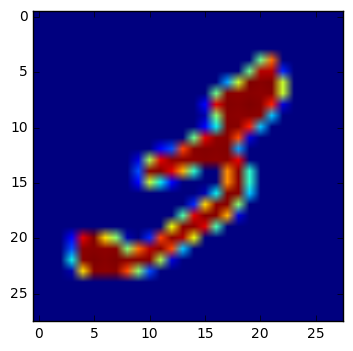

In [46]:
pred = Y[one] == -1
miss = [i for i,j in enumerate(pred) if j==0]

for i in miss:
    create_2D_image(X[i,0:-1],w=28, h=28)
    plt.show()